<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [1]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [2]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Check whether GPU is available

In [3]:
import torch
torch.cuda.is_available()

True

Load data from prepared local csv files

In [4]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

Load price history
* Past covariates

In [5]:
stocks_file = 'data/all_stocks_price_hist.csv.bz2'

In [6]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0, on_bad_lines='warn')
stocks_df



BEAM                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-16 00:00:00  25.280001  25.690001  24.410000  25.100000  25.100000   
2024-01-17 00:00:00  24.340000  24.785000  23.559999  24.129999  24.129999   
2024-01-18 00:00:00  24.389999  24.400000  23.080000  23.459999  23.459999   
2024-01-19 00:00:00  23.459999  23.990000  22.750000  23.690001  23.690001   
2024-01-22 00:00:00  24.020000  25.750000  23.820000  24.629999  24.629999   

                                    CRDO                                   \
                       Volume       Open       High        Low      Close   
Date                                                                        
1962-01-02 00:00:00       NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00       NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00       NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00       NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00       NaN        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
2024-01-16 00:00:00  902300.0  18.870001  19.850000  18.570000  18.990000   
2024-01-17 00:00:00  787500.0  18.770000  18.879999  17.969999  18.750000   
2024-01-18 00:00:00  665800.0  19.360001  19.412001  18.740000  19.190001   
2024-01-19 00:00:00  748400.0  19.500000  20.840000  19.150000  20.780001   
2024-01-22 00:00:00  507595.0  21.033001  21.600000  20.850000  21.555000   

                     ...    VGR                                     LTC  \
                     ...    Low   Close Adj Close     Volume       Open   
Date                 ...                                                  
1962-01-02 00:00:00  ...    NaN     NaN       NaN        NaN        NaN   
1962-01-03 00:00:00  ...    NaN     NaN       NaN        NaN        NaN   
1962-01-04 00:00:00  ...    NaN     NaN       NaN        NaN        NaN   
1962-01-05 00:00:00  ...    NaN     NaN       NaN        NaN        NaN   
1962-01-08 00:00:00  ...    NaN     NaN       NaN        NaN        NaN   
...                  ...    ...     ...       ...        ...        ...   
2024-01-16 00:00:00  ...  10.65  10.660    10.660   806100.0  32.849998   
2024-01-17 00:00:00  ...  10.30  10.300    10.300   901500.0  32.700001   
2024-01-18 00:00:00  ...  10.19  10.310    10.310  1008000.0  32.000000   
2024-01-19 00:00:00  ...  10.14  10.290    10.290  2874000.0  31.850000   
2024-01-22 00:00:00  ...  10.34  10.475    10.475   522141.0  31.950001   

                                                                           
                          High        Low      Close  Adj Close    Volume  
Date                                                                       
1962-01-02 00:00:00        NaN        NaN        NaN        NaN       NaN  
1962-01-03 00:00:00        NaN        NaN        NaN        NaN       NaN  
1962-01-04 00:00:00        NaN        NaN        NaN        NaN       NaN  
1962-01-05 00:00:00        NaN        NaN        NaN        NaN       NaN  
1962-01-08 00:00:00        NaN        NaN        NaN        NaN       NaN  
...                        ...        ...        ...        ...       ...  
2024-01-16 00:00:00  33.150002  32.820000  32.950001  32.950001  315000.0  
2024-01-17 00:00:00  32.980000  31.799999  

In [7]:
stocks_df.columns.levels[0]

Index(['-', 'A', 'AADI', 'AAL', 'AAN', 'AAON', 'AAPL', 'AAT', 'ABBNY', 'ABBV',
       ...
       'ZTS', 'ZUMZ', 'ZUO', 'ZURA', 'ZVIA', 'ZVRA', 'ZWS', 'ZYME', 'ZYXI',
       ' '],
      dtype='object', length=2656)

In [8]:
stocks_df[['ZS']]

ZS                                      \
                           Open        High         Low       Close   
Date                                                                  
1962-01-02 00:00:00         NaN         NaN         NaN         NaN   
1962-01-03 00:00:00         NaN         NaN         NaN         NaN   
1962-01-04 00:00:00         NaN         NaN         NaN         NaN   
1962-01-05 00:00:00         NaN         NaN         NaN         NaN   
1962-01-08 00:00:00         NaN         NaN         NaN         NaN   
...                         ...         ...         ...         ...   
2024-01-16 00:00:00  230.000000  233.279999  228.779999  232.179993   
2024-01-17 00:00:00  228.899994  230.330002  221.500000  225.330002   
2024-01-18 00:00:00  230.309998  231.369995  224.929993  227.910004   
2024-01-19 00:00:00  229.000000  231.360001  226.837997  231.289993   
2024-01-22 00:00:00  239.679993  240.399994  235.080002  239.839996   

                                            
                      Adj Close     Volume  
Date                                        
1962-01-02 00:00:00         NaN        NaN  
1962-01-03 00:00:00         NaN        NaN  
1962-01-04 00:00:00         NaN        NaN  
1962-01-05 00:00:00         NaN        NaN  
1962-01-08 00:00:00         NaN        NaN  
...                         ...        ...  
2024-01-16 00:00:00  232.179993  1517400.0  
2024-01-17 00:00:00  225.330002  2349600.0  
2024-01-18 00:00:00  227.910004  1909800.0  
2024-01-19 00:00:00  231.289993  1543900.0  
2024-01-22 00:00:00  239.839996  1096049.0  

[15620 rows x 6 columns]

## Config Model Hyper Parameters

In [9]:
import random

n_stocks = 200 # -1 for all, otherwise a number like 300
n_epochs = 5 # model training epochs

train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data

n_test_range_days = train_history+3*pred_horizon
print(f'n_test_range_days: {n_test_range_days}')


# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = n_test_range_days*3
print(f'min_samples: {min_samples}')


stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


n_test_range_days: 630
min_samples: 1890
<class 'pandas.core.indexes.base.Index'>


In [10]:
print(list(stock_tickers))

['-', 'A', 'AADI', 'AAL', 'AAN', 'AAON', 'AAPL', 'AAT', 'ABBNY', 'ABBV', 'ABCB', 'ABG', 'ABM', 'ABNB', 'ABR', 'ABT', 'ABUS', 'ABVX', 'ACA', 'ACAD', 'ACCD', 'ACCO', 'ACDC', 'ACEL', 'ACET', 'ACGL', 'ACHR', 'ACIC', 'ACIW', 'ACLS', 'ACLX', 'ACMR', 'ACN', 'ACNB', 'ACRE', 'ACRS', 'ACRV', 'ACT', 'ACTG', 'ACVA', 'ADBE', 'ADEA', 'ADI', 'ADM', 'ADMA', 'ADNT', 'ADP', 'ADPT', 'ADRO', 'ADSK', 'ADTN', 'ADUS', 'ADV', 'AEE', 'AEHR', 'AEIS', 'AEL', 'AEO', 'AEP', 'AER', 'AES', 'AESI', 'AEVA', 'AFCG', 'AFL', 'AFRI', 'AFRM', 'AFYA', 'AGEN', 'AGIO', 'AGM', 'AGO', 'AGS', 'AGTI', 'AGX', 'AGYS', 'AHCO', 'AHH', 'AI', 'AIG', 'AIN', 'AIR', 'AIRS', 'AIT', 'AIV', 'AIZ', 'AJG', 'AKAM', 'AKR', 'AKRO', 'AKTS', 'AKYA', 'ALB', 'ALCO', 'ALDX', 'ALE', 'ALEC', 'ALEX', 'ALG', 'ALGN', 'ALGT', 'ALHC', 'ALIT', 'ALKS', 'ALKT', 'ALL', 'ALLE', 'ALLK', 'ALLO', 'ALLY', 'ALNT', 'ALPN', 'ALRM', 'ALRS', 'ALT', 'ALTG', 'ALTI', 'ALTM', 'ALTR', 'ALVR', 'ALX', 'ALXO', 'AMAL', 'AMAT', 'AMBA', 'AMBC', 'AMCR', 'AMCX', 'AMD', 'AME', 'AMEH', 

In [11]:
print(stock_tickers[0])

-


In [12]:

# use only a small subset of stocks while testing impact of covariates on model performance
if n_stocks != -1:
    stock_tickers = random.sample(list(stock_tickers), n_stocks)
# stock_tickers = list(stock_tickers) 
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # UPDATE: Do not drop Close as it carries unique information about the relationships between OHLC and Adj Close
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist # .drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


ticker: PJT
ticker historic data:                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-09-22  30.000000  30.000000  29.160000  29.160000  26.559700    5400.0
2015-09-23  28.750000  28.750000  28.750000  28.750000  26.186260     300.0
2015-09-24  28.500000  28.500000  27.930000  27.980000  25.484922   80100.0
2015-09-25  27.980000  27.980000  27.340000  27.500000  25.047731   13300.0
2015-09-28  27.500000  27.500000  25.000000  26.200001  23.863657   80900.0
...               ...        ...        ...        ...        ...       ...
2024-01-16  94.180000  96.379997  93.871002  96.199997  96.199997  183500.0
2024-01-17  95.480003  97.070000  95.480003  96.680000  96.680000  177500.0
2024-01-18  97.040001  97.407997  95.875000  96.599998  96.599998  134600.0
2024-01-19  97.389999  98.089996  95.945000  98.089996  98.089996  155100.0
2024-01-22  98.739998  99.599998  98.771896  99.080002

ticker: HOFT
ticker historic data:                  Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2002-06-27   7.875000   8.025000   7.720000   7.750000   4.476692  80800.0
2002-06-28   7.945000   8.000000   7.800000   7.800000   4.505575  19200.0
2002-07-01   8.150000   8.200000   7.875000   8.200000   4.736628   4400.0
2002-07-02   8.195000   8.195000   7.780000   7.995000   4.618213   4000.0
2002-07-03   7.875000   7.975000   7.750000   7.975000   4.606658  10600.0
...               ...        ...        ...        ...        ...      ...
2024-01-16  23.150000  23.559999  23.090000  23.530001  23.530001  29000.0
2024-01-17  23.150000  23.770000  23.070000  23.600000  23.600000  37500.0
2024-01-18  23.730000  23.730000  23.309999  23.590000  23.590000  21100.0
2024-01-19  23.690001  23.690001  23.049999  23.559999  23.559999  25700.0
2024-01-22  23.830000  24.070000  23.750099  23.809999  23.809999

In [13]:
ticker_dict.keys()

dict_keys(['PJT', 'SYK', 'MOV', 'VMC', 'CLDT', 'OI', 'UFPI', 'DBRG', 'RDNT', 'KALV', 'RPD', 'CBU', 'OMER', 'HOFT', 'AMSF', 'VKTX', 'PLBC', 'EMN', 'HWKN', 'FET', 'DDD', 'BH', 'AES', 'HPQ', 'BGFV', 'KMB', 'HOV', 'SIGI', 'HAFC', 'CCRN', 'SMTI', 'HMST', 'CORT', 'PRMW', 'HASI', 'BCML', 'NAT', 'OIS', 'BLDR', 'LYB', 'RIGL', 'HMN', 'PLAB', 'ZWS', 'PSTG', 'HBIO', 'GS', 'EGAN', 'CAKE', 'USLM', 'SMCI', 'VNDA', 'INN', 'WERN', 'HLX', 'CENT', 'OTLK', 'HTBI', 'ALPN', 'SPWR', 'UVE', 'EA', 'PM', 'PAYC', 'SCWO', 'EPM', 'PFE', 'SFM', 'FMNB', 'LUV', 'CZR', 'SPLK', 'VECO', 'PARA', 'UTI', 'PRGS', 'WHR', 'GPRO', 'IRWD', 'BGC', 'OXY', 'HELE', 'HRL', 'ERII', 'ORC', 'WSBF', 'CMI', 'MRTN', 'RBCAA', 'PGTI', 'CF', 'AJG', 'SHAK', 'ABR', 'EBTC', 'PODD', 'KAR', 'IHG', 'ARE', 'AER', 'GM', 'KRNY', 'CI', 'VALU', 'OFLX', 'NDLS', 'CCOI', 'ACCO', 'KTOS', 'NVTA', 'DCO', 'GPRE', 'SKY', 'TPR', 'PLSE', 'MNST', 'SBSI', 'AMCX', 'COKE', 'GRBK', 'VIAV', 'AEHR', 'WNC', 'STRS', 'LKQ', 'NX', 'TRC', 'CYBR', 'SXI', 'WFC', 'DEI', 'KEY',

In [14]:
type(list(ticker_dict.keys()))

list

In [15]:
list(ticker_dict.keys())[0]

'PJT'

In [16]:
# type(raw_df.index)

In [17]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [18]:
# raw_df

In [19]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='B') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


{'PJT': <TimeSeries (DataArray) (Date: 2175, component: 6, sample: 1)>
 array([[[3.00000000e+01],
         [3.00000000e+01],
         [2.91599998e+01],
         [2.91599998e+01],
         [2.65597000e+01],
         [5.40000000e+03]],
 
        [[2.87500000e+01],
         [2.87500000e+01],
         [2.87500000e+01],
         [2.87500000e+01],
         [2.61862602e+01],
         [3.00000000e+02]],
 
        [[2.85000000e+01],
         [2.85000000e+01],
         [2.79300003e+01],
         [2.79799995e+01],
         [2.54849224e+01],
         [8.01000000e+04]],
 ...
        [[9.70400009e+01],
         [9.74079971e+01],
         [9.58750000e+01],
         [9.65999985e+01],
         [9.65999985e+01],
         [1.34600000e+05]],
 
        [[9.73899994e+01],
         [9.80899963e+01],
         [9.59449997e+01],
         [9.80899963e+01],
         [9.80899963e+01],
         [1.55100000e+05]],
 
        [[9.87399979e+01],
         [9.95999985e+01],
         [9.87718964e+01],
         [9.90800018

Prepare multiple series - one per stock ticker

In [20]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



ticker: PJT gaps: 
     gap_start    gap_end  gap_size
0  2015-11-26 2015-11-26         1
1  2015-12-25 2015-12-25         1
2  2016-01-01 2016-01-01         1
3  2016-01-18 2016-01-18         1
4  2016-02-15 2016-02-15         1
..        ...        ...       ...
73 2023-09-04 2023-09-04         1
74 2023-11-23 2023-11-23         1
75 2023-12-25 2023-12-25         1
76 2024-01-01 2024-01-01         1
77 2024-01-15 2024-01-15         1

[78 rows x 3 columns]
ticker: PJT gaps after filler: 
 Empty DataFrame
Columns: [gap_start, gap_end]
Index: []
ticker: SYK gaps: 
      gap_start    gap_end  gap_size
0   1980-04-04 1980-04-04         1
1   1980-05-26 1980-05-26         1
2   1980-07-04 1980-07-04         1
3   1980-09-01 1980-09-01         1
4   1980-11-04 1980-11-04         1
..         ...        ...       ...
376 2023-09-04 2023-09-04         1
377 2023-11-23 2023-11-23         1
378 2023-12-25 2023-12-25         1
379 2024-01-01 2024-01-01         1
380 2024-01-15 2024-01-15       

In [21]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1991-01-01')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: PJT , <TimeSeries (DataArray) (Date: 2175, component: 6, sample: 1)>
array([[[3.00000000e+01],
        [3.00000000e+01],
        [2.91599998e+01],
        [2.91599998e+01],
        [2.65597000e+01],
        [5.40000000e+03]],

       [[2.87500000e+01],
        [2.87500000e+01],
        [2.87500000e+01],
        [2.87500000e+01],
        [2.61862602e+01],
        [3.00000000e+02]],

       [[2.85000000e+01],
        [2.85000000e+01],
        [2.79300003e+01],
        [2.79799995e+01],
        [2.54849224e+01],
        [8.01000000e+04]],
...
       [[9.70400009e+01],
        [9.74079971e+01],
        [9.58750000e+01],
        [9.65999985e+01],
        [9.65999985e+01],
        [1.34600000e+05]],

       [[9.73899994e+01],
        [9.80899963e+01],
        [9.59449997e+01],
        [9.80899963e+01],
        [9.80899963e+01],
        [1.55100000e+05]],

       [[9.87399979e+01],
        [9.95999985e+01],
        [9.87718964e+01],
        [9.90800018e+01],
        [9.90800018e+01],


In [22]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    # print(f'ticker: {t} , {ticker_series[t]}')


In [23]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [24]:
ticker_series

{'PJT': <TimeSeries (DataArray) (Date: 2175, component: 7, sample: 1)>
 array([[[3.00000000e+01],
         [3.00000000e+01],
         [2.91599998e+01],
         ...,
         [2.65597000e+01],
         [5.40000000e+03],
         [0.00000000e+00]],
 
        [[2.87500000e+01],
         [2.87500000e+01],
         [2.87500000e+01],
         ...,
         [2.61862602e+01],
         [3.00000000e+02],
         [0.00000000e+00]],
 
        [[2.85000000e+01],
         [2.85000000e+01],
         [2.79300003e+01],
         ...,
 ...
         ...,
         [9.65999985e+01],
         [1.34600000e+05],
         [0.00000000e+00]],
 
        [[9.73899994e+01],
         [9.80899963e+01],
         [9.59449997e+01],
         ...,
         [9.80899963e+01],
         [1.55100000e+05],
         [0.00000000e+00]],
 
        [[9.87399979e+01],
         [9.95999985e+01],
         [9.87718964e+01],
         ...,
         [9.90800018e+01],
         [5.77210000e+04],
         [0.00000000e+00]]])
 Coordinates:
  

In [25]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [26]:
# prepare target univariate series for Close price
# target_series = {t: ticker_series[t].univariate_component('Close') for t in ticker_series.keys()}

target_columns = ['Open', 'Close']

def drop_non_target_columns(series):
    cols = series.columns
    non_target_columns = list(set(cols) - set(target_columns))
    new_series = series.drop_columns(col_names=non_target_columns)
    # print(f'dropped non-target columns: {non_target_columns}')
    return new_series

# prepare target multivariate series for Open, Close and Volume
target_series = {t: drop_non_target_columns(s) for t,s in ticker_series.items()}

target_series

{'PJT': <TimeSeries (DataArray) (Date: 2175, component: 2, sample: 1)>
 array([[[30.        ],
         [29.15999985]],
 
        [[28.75      ],
         [28.75      ]],
 
        [[28.5       ],
         [27.97999954]],
 
        ...,
 
        [[97.04000092],
         [96.59999847]],
 
        [[97.38999939],
         [98.08999634]],
 
        [[98.73999786],
         [99.08000183]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2015-09-22 2015-09-23 ... 2024-01-22
   * component  (component) object 'Open' 'Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'SYK': <TimeSeries (DataArray) (Date: 8625, component: 2, sample: 1)>
 array([[[  1.9375    ],
         [  1.9140625 ]],
 
        [[  1.9375    ],
         [  1.875     ]],
 
        [[  1.875     ],
         [  1.796875  ]],
 
        ...,
 
        [[315.8500061 ],
         [314.72000122]],
 
        [[315.07998657],
         [315.04998779]],
 
     

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [27]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=target_columns + ['holidays']) for t in ticker_series.keys()}

past_covariates


{'PJT': <TimeSeries (DataArray) (Date: 2175, component: 4, sample: 1)>
 array([[[3.00000000e+01],
         [2.91599998e+01],
         [2.65597000e+01],
         [5.40000000e+03]],
 
        [[2.87500000e+01],
         [2.87500000e+01],
         [2.61862602e+01],
         [3.00000000e+02]],
 
        [[2.85000000e+01],
         [2.79300003e+01],
         [2.54849224e+01],
         [8.01000000e+04]],
 
        ...,
 
        [[9.74079971e+01],
         [9.58750000e+01],
         [9.65999985e+01],
         [1.34600000e+05]],
 
        [[9.80899963e+01],
         [9.59449997e+01],
         [9.80899963e+01],
         [1.55100000e+05]],
 
        [[9.95999985e+01],
         [9.87718964e+01],
         [9.90800018e+01],
         [5.77210000e+04]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2015-09-22 2015-09-23 ... 2024-01-22
   * component  (component) object 'High' 'Low' 'Adj Close' 'Volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hie

In [28]:
past_covariates.keys()

dict_keys(['PJT', 'SYK', 'MOV', 'VMC', 'CLDT', 'OI', 'UFPI', 'DBRG', 'RDNT', 'KALV', 'RPD', 'CBU', 'OMER', 'HOFT', 'AMSF', 'VKTX', 'PLBC', 'EMN', 'HWKN', 'FET', 'DDD', 'BH', 'AES', 'HPQ', 'BGFV', 'KMB', 'HOV', 'SIGI', 'HAFC', 'CCRN', 'SMTI', 'HMST', 'CORT', 'PRMW', 'HASI', 'BCML', 'NAT', 'OIS', 'BLDR', 'LYB', 'RIGL', 'HMN', 'PLAB', 'ZWS', 'PSTG', 'HBIO', 'GS', 'EGAN', 'CAKE', 'USLM', 'SMCI', 'VNDA', 'INN', 'WERN', 'HLX', 'CENT', 'OTLK', 'HTBI', 'ALPN', 'SPWR', 'UVE', 'EA', 'PM', 'PAYC', 'SCWO', 'EPM', 'PFE', 'SFM', 'FMNB', 'LUV', 'CZR', 'SPLK', 'VECO', 'PARA', 'UTI', 'PRGS', 'WHR', 'GPRO', 'IRWD', 'BGC', 'OXY', 'HELE', 'HRL', 'ERII', 'ORC', 'WSBF', 'CMI', 'MRTN', 'RBCAA', 'PGTI', 'CF', 'AJG', 'SHAK', 'ABR', 'EBTC', 'PODD', 'KAR', 'IHG', 'ARE', 'AER', 'GM', 'KRNY', 'CI', 'VALU', 'OFLX', 'NDLS', 'CCOI', 'ACCO', 'KTOS', 'NVTA', 'DCO', 'GPRE', 'SKY', 'TPR', 'PLSE', 'MNST', 'SBSI', 'AMCX', 'COKE', 'GRBK', 'VIAV', 'AEHR', 'WNC', 'STRS', 'LKQ', 'NX', 'TRC', 'CYBR', 'SXI', 'WFC', 'DEI', 'KEY',

PJT past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
SYK past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
MOV past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
VMC past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

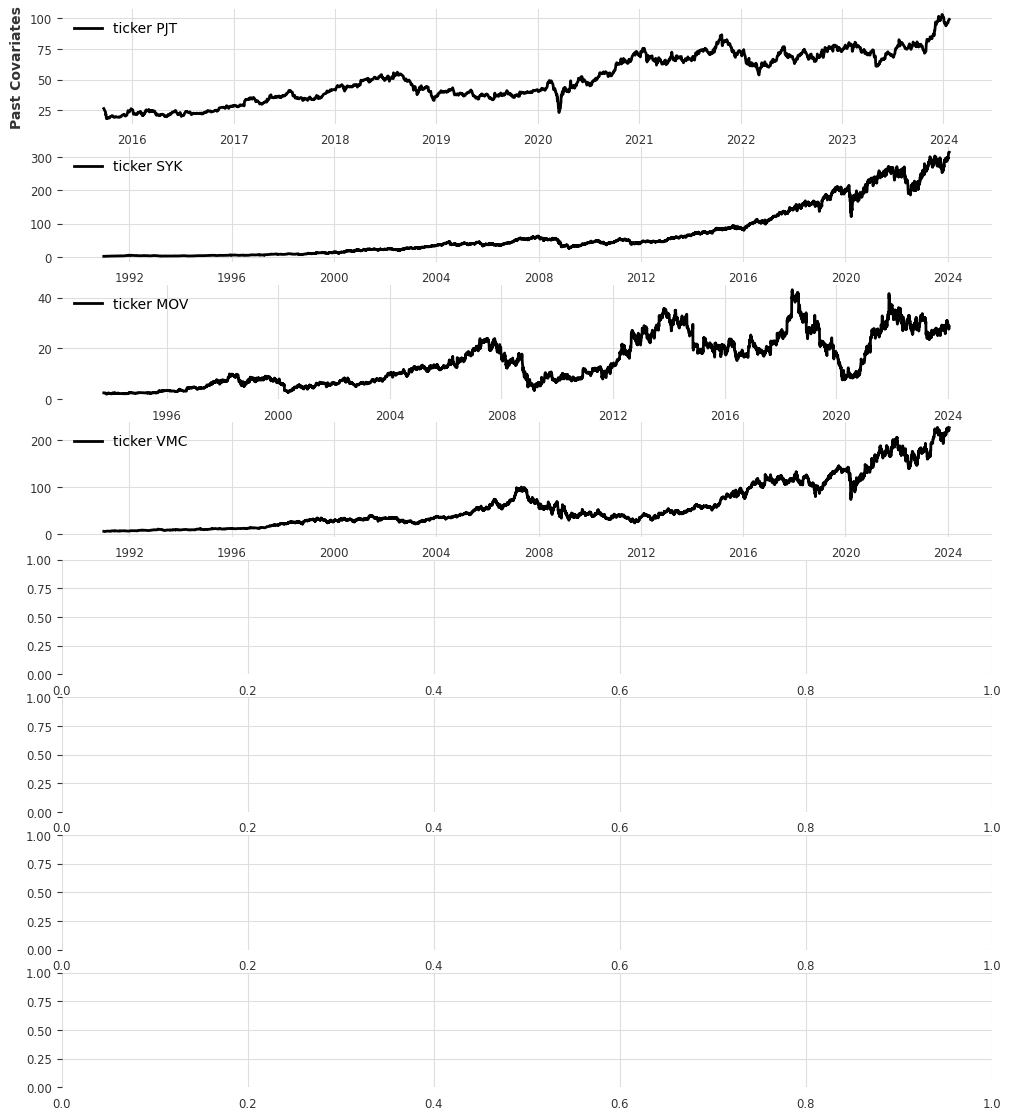

In [29]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=n_plot_samples*2, ncols=1, figsize=(12, 14))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].univariate_component('Adj Close').plot(label=f'ticker {t} ', ax=axes[i])
        # past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [30]:
import pandas as pd

earnings_loaded_df = pd.read_csv('data/earnings_calendar.csv.bz2')
print(earnings_loaded_df)

       symbol        date     eps  epsEstimated time       revenue  \
0          CF  2024-10-31     NaN           NaN  amc           NaN   
1          CF  2024-08-08     NaN           NaN  amc           NaN   
2          CF  2024-05-02     NaN           NaN  amc           NaN   
3          CF  2024-02-14     NaN          1.56  bmo           NaN   
4          CF  2023-11-01  0.8500          0.94  amc  1.273000e+09   
...       ...         ...     ...           ...  ...           ...   
214890    GPI  1998-04-21  0.2000          0.17  bmo  2.539000e+08   
214891    GPI  1998-02-17  0.1500          0.15  bmo  2.132000e+08   
214892    GPI  1997-09-30  0.2422           NaN  bmo  2.387000e+08   
214893    GPI  1997-06-30  0.1900           NaN  bmo  2.252000e+08   
214894    GPI  1997-03-31  0.1800           NaN  bmo  2.252000e+08   

        revenueEstimated updatedFromDate fiscalDateEnding  
0                    NaN      2024-01-22       2024-09-30  
1                    NaN      2024-01-2

In [31]:
earnings_loaded_df.index.is_unique

True

In [32]:
earnings_loaded_df.index

RangeIndex(start=0, stop=214895, step=1)

In [33]:
len(earnings_loaded_df.index)

214895

In [34]:
earnings_loaded_df['date'] = pd.to_datetime(earnings_loaded_df['date'])

In [35]:
earnings_unique = earnings_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [36]:
assert not earnings_unique.duplicated().any()

In [37]:
earnings_unique

symbol       date     eps  epsEstimated time       revenue  \
0          CF 2024-10-31     NaN           NaN  amc           NaN   
1          CF 2024-08-08     NaN           NaN  amc           NaN   
2          CF 2024-05-02     NaN           NaN  amc           NaN   
3          CF 2024-02-14     NaN          1.56  bmo           NaN   
4          CF 2023-11-01  0.8500          0.94  amc  1.273000e+09   
...       ...        ...     ...           ...  ...           ...   
214890    GPI 1998-04-21  0.2000          0.17  bmo  2.539000e+08   
214891    GPI 1998-02-17  0.1500          0.15  bmo  2.132000e+08   
214892    GPI 1997-09-30  0.2422           NaN  bmo  2.387000e+08   
214893    GPI 1997-06-30  0.1900           NaN  bmo  2.252000e+08   
214894    GPI 1997-03-31  0.1800           NaN  bmo  2.252000e+08   

        revenueEstimated updatedFromDate fiscalDateEnding  
0                    NaN      2024-01-22       2024-09-30  
1                    NaN      2024-01-22       2024-06-30  
2                    NaN      2024-01-22       2024-03-30  
3           1.500270e+09      2024-01-22       2023-12-30  
4           1.300920e+09      2024-01-22       2023-09-30  
...                  ...             ...              ...  
214890      2.158150e+08      2023-12-04       1998-03-31  
214891      1.679000e+08      2023-12-04       1997-12-31  
214892               NaN      2023-12-04       1997-09-30  
214893               NaN      2023-12-04       1997-06-30  
214894               NaN      2023-12-04       1997-03-31  

[214801 rows x 9 columns]

In [38]:
earnings_unique = earnings_unique.set_index(keys=['symbol', 'date'])

In [39]:
earnings_unique

eps  epsEstimated time       revenue  revenueEstimated  \
symbol date                                                                    
CF     2024-10-31     NaN           NaN  amc           NaN               NaN   
       2024-08-08     NaN           NaN  amc           NaN               NaN   
       2024-05-02     NaN           NaN  amc           NaN               NaN   
       2024-02-14     NaN          1.56  bmo           NaN      1.500270e+09   
       2023-11-01  0.8500          0.94  amc  1.273000e+09      1.300920e+09   
...                   ...           ...  ...           ...               ...   
GPI    1998-04-21  0.2000          0.17  bmo  2.539000e+08      2.158150e+08   
       1998-02-17  0.1500          0.15  bmo  2.132000e+08      1.679000e+08   
       1997-09-30  0.2422           NaN  bmo  2.387000e+08               NaN   
       1997-06-30  0.1900           NaN  bmo  2.252000e+08               NaN   
       1997-03-31  0.1800           NaN  bmo  2.252000e+08               NaN   

                  updatedFromDate fiscalDateEnding  
symbol date                                         
CF     2024-10-31      2024-01-22       2024-09-30  
       2024-08-08      2024-01-22       2024-06-30  
       2024-05-02      2024-01-22       2024-03-30  
       2024-02-14      2024-01-22       2023-12-30  
       2023-11-01      2024-01-22       2023-09-30  
...                           ...              ...  
GPI    1998-04-21      2023-12-04       1998-03-31  
       1998-02-17      2023-12-04       1997-12-31  
       1997-09-30      2023-12-04       1997-09-30  
       1997-06-30      2023-12-04       1997-06-30  
       1997-03-31      2023-12-04       1997-03-31  

[214801 rows x 7 columns]

In [40]:
assert earnings_unique.index.has_duplicates == False

In [41]:
# check if data for a given symbol was saved and loaded as expected
earnings_unique.xs('LRN', level='symbol')

eps  epsEstimated time      revenue  revenueEstimated  \
date                                                                    
2024-10-22      NaN           NaN  amc          NaN               NaN   
2024-08-13      NaN           NaN  amc          NaN               NaN   
2024-04-23      NaN           NaN  amc          NaN               NaN   
2024-01-23      NaN          1.34  amc          NaN       500850000.0   
2023-10-24  0.11000         -0.35  amc  480181000.0       451150000.0   
...             ...           ...  ...          ...               ...   
2006-06-30  0.17150           NaN  amc   29225000.0               NaN   
2006-03-31  0.17200           NaN  amc   29226000.0               NaN   
2005-12-31  0.17200           NaN  amc   29226000.0               NaN   
2005-09-30  0.17200           NaN  amc   29226000.0               NaN   
2001-06-30  0.00066           NaN  amc  455211000.0               NaN   

           updatedFromDate fiscalDateEnding  
date                                         
2024-10-22      2024-01-22       2024-09-30  
2024-08-13      2024-01-22       2024-06-30  
2024-04-23      2024-01-22       2024-03-30  
2024-01-23      2024-01-22       2023-12-30  
2023-10-24      2024-01-22       2023-09-30  
...                    ...              ...  
2006-06-30      2023-12-04       2006-06-30  
2006-03-31      2023-12-04       2006-03-31  
2005-12-31      2023-12-04       2005-12-31  
2005-09-30      2023-12-04       2005-09-30  
2001-06-30      2023-12-04       2001-06-30  

[78 rows x 7 columns]

In [42]:
print(earnings_unique.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated updatedFromDate fiscalDateEnding
date                                                                                               
2024-10-22   NaN           NaN  amc          NaN               NaN      2024-01-22       2024-09-30
2024-08-13   NaN           NaN  amc          NaN               NaN      2024-01-22       2024-06-30
2024-04-23   NaN           NaN  amc          NaN               NaN      2024-01-22       2024-03-30
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08      2024-01-22       2023-12-30
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08      2024-01-22       2023-09-30
2023-08-15  1.01        0.8700  amc  483489000.0      4.607000e+08      2023-12-04       2023-06-30
2023-04-25  1.30        1.0700  amc  470284000.0      4.607000e+08      2023-12-04       2023-03-31
2023-01-24  1.19        1.0400  amc  458435000.0               NaN      2023-12-04       2022-12-31


In [43]:
# get a clean deep copy so it is easier to debug further data cleanup steps
earnings_expanded_df = earnings_unique.copy()

In [44]:
# convert date strings to numerical representation
ufd = pd.to_datetime(earnings_expanded_df['updatedFromDate'])
ufd_year = ufd.dt.year
ufd_month = ufd.dt.month
ufd_day = ufd.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_year', value=ufd_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_month', value=ufd_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_day', value=ufd_day)
earnings_expanded_df.pop('updatedFromDate')


symbol  date      
CF      2024-10-31    2024-01-22
        2024-08-08    2024-01-22
        2024-05-02    2024-01-22
        2024-02-14    2024-01-22
        2023-11-01    2024-01-22
                         ...    
GPI     1998-04-21    2023-12-04
        1998-02-17    2023-12-04
        1997-09-30    2023-12-04
        1997-06-30    2023-12-04
        1997-03-31    2023-12-04
Name: updatedFromDate, Length: 214801, dtype: object

In [45]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated fiscalDateEnding  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year
date                                                                                                                                                 
2024-10-22   NaN           NaN  amc          NaN               NaN       2024-09-30                   22                      1                  2024
2024-08-13   NaN           NaN  amc          NaN               NaN       2024-06-30                   22                      1                  2024
2024-04-23   NaN           NaN  amc          NaN               NaN       2024-03-30                   22                      1                  2024
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08       2023-12-30                   22                      1                  2024
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08       2023-09-30                 

In [46]:
# convert date strings to numerical representation
fde = pd.to_datetime(earnings_expanded_df['fiscalDateEnding'])
fde_year = fde.dt.year
fde_month = fde.dt.month
fde_day = fde.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_year', value=fde_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_month', value=fde_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_day', value=fde_day)
earnings_expanded_df.pop('fiscalDateEnding')


symbol  date      
CF      2024-10-31    2024-09-30
        2024-08-08    2024-06-30
        2024-05-02    2024-03-30
        2024-02-14    2023-12-30
        2023-11-01    2023-09-30
                         ...    
GPI     1998-04-21    1998-03-31
        1998-02-17    1997-12-31
        1997-09-30    1997-09-30
        1997-06-30    1997-06-30
        1997-03-31    1997-03-31
Name: fiscalDateEnding, Length: 214801, dtype: object

In [47]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                     
2024-10-22   NaN           NaN  amc          NaN               NaN                   22                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN  amc          NaN               NaN                   22                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN  amc          NaN               NaN                   22                      1                  2024                    30                       3              

In [48]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
earnings_expanded_df['time'] = earnings_expanded_df['time'].replace(['bmo', 'amc', '--', 'dmh'],
                        [0, 1, -1, -1], inplace=False).astype('int32')



In [49]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated  time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                      
2024-10-22   NaN           NaN     1          NaN               NaN                   22                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN     1          NaN               NaN                   22                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN     1          NaN               NaN                   22                      1                  2024                    30                       3         

In [50]:
from darts import TimeSeries

type(earnings_expanded_df.index)

pandas.core.indexes.multi.MultiIndex

In [51]:
earnings_expanded_df.index.names

FrozenList(['symbol', 'date'])

In [52]:
earnings_expanded_df.dtypes

eps                       float64
epsEstimated              float64
time                        int32
revenue                   float64
revenueEstimated          float64
updatedFromDate_day         int32
updatedFromDate_month       int32
updatedFromDate_year        int32
fiscalDateEnding_day        int32
fiscalDateEnding_month      int32
fiscalDateEnding_year       int32
dtype: object

In [53]:
# credit for implementation: https://stackoverflow.com/a/39068260/12015435
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))


In [54]:
t_earn = earnings_expanded_df.loc[['LRN']]
t_earn = t_earn.droplevel('symbol')
t_earn.index = pd.to_datetime(t_earn.index)
print(f'index type for {t}: {type(t_earn.index)}')
assert not t_earn.index.duplicated().any()

for i in t_earn.index:
    if not is_business_day(i):
        print(f'earnings record date is not a business day: \n{t_earn.loc[[i]]}')



index type for ILMN: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
earnings record date is not a business day: 
               eps  epsEstimated  time     revenue  revenueEstimated  \
date                                                                   
2007-09-30  0.1201           NaN     1  27196000.0               NaN   

            updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2007-09-30                    4                     12                  2023   

            fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2007-09-30                    30                       9   

            fiscalDateEnding_year  
date                               
2007-09-30                   2007  
earnings record date is not a business day: 
                eps  epsEstimated  time     revenue  revenueEstimated  \
date           

In [55]:
len(t_earn.index)

78

In [56]:
# align all dates with Business days
from pandas.tseries.offsets import BDay

def to_biz_day(date=None, report_time=None):
    if not is_business_day(date):
        if report_time == 1 or report_time =='amc':
                return date-BDay(n=1)
        else: 
            return date+BDay(n=1)
    else:
         return date

def align_to_business_days(t_earn=None):
    assert not t_earn.index.isnull().any()
    new_index = t_earn.index.map(lambda x : to_biz_day(date=x, report_time=t_earn.at[x, 'time']))
    t_earn.index = new_index
    if t_earn.index.isnull().any():
         print(t_earn[t_earn.index.isnull()])
    for i in t_earn.index:
        assert is_business_day(i)
    return t_earn


In [57]:
# backfill quarterly earnigs and revenue estimates so that the model can see the next quarter's estimates during the previou s quarter days

def back_fill_earn_estimates(t_earn=None):
    t_earn['time'].bfill(inplace=True)
    t_earn['epsEstimated'].bfill(inplace=True)
    t_earn['revenueEstimated'].bfill(inplace=True)
    t_earn['fiscalDateEnding_day'].bfill(inplace=True)
    t_earn['fiscalDateEnding_month'].bfill(inplace=True)
    t_earn['fiscalDateEnding_year'].bfill(inplace=True)
    return t_earn



In [58]:
# convert earnings dataframe to series

t_earn_series = {}
for t in list(ticker_series.keys()):
    # print(f'ticker: {t}')
    t_earn = earnings_expanded_df.loc[[t]].copy()
    t_earn = t_earn.droplevel('symbol')
    t_earn.index = pd.to_datetime(t_earn.index)
    # print(f'index type for {t}: {type(t_earn.index)}')
    assert not t_earn.index.duplicated().any()
    assert not t_earn.index.isnull().any()
    t_earn = align_to_business_days(t_earn)
    # print(f't_earn freq: {t_earn.index}')
    tes_tmp = TimeSeries.from_dataframe(t_earn, freq='B', fill_missing_dates=True)
    t_earn = back_fill_earn_estimates(t_earn=tes_tmp.pd_dataframe())
    tes = TimeSeries.from_dataframe(t_earn, fillna_value=-1)
    assert len(tes.gaps()) == 0
    t_earn_series[t] = tes


In [59]:
t

'ILMN'

In [60]:
t_earn


component       eps  epsEstimated  time  revenue  revenueEstimated  \
date                                                                 
2000-03-31 -1.11404          -0.1   1.0  83205.0     777777.777778   
2000-04-03      NaN          -0.1   1.0      NaN     777777.777778   
2000-04-04      NaN          -0.1   1.0      NaN     777777.777778   
2000-04-05      NaN          -0.1   1.0      NaN     777777.777778   
2000-04-06      NaN          -0.1   1.0      NaN     777777.777778   
...             ...           ...   ...      ...               ...   
2024-11-01      NaN           NaN   1.0      NaN               NaN   
2024-11-04      NaN           NaN   1.0      NaN               NaN   
2024-11-05      NaN           NaN   1.0      NaN               NaN   
2024-11-06      NaN           NaN   1.0      NaN               NaN   
2024-11-07      NaN           NaN   1.0      NaN               NaN   

component   updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2000-03-31                  4.0                   12.0                2023.0   
2000-04-03                  NaN                    NaN                   NaN   
2000-04-04                  NaN                    NaN                   NaN   
2000-04-05                  NaN                    NaN                   NaN   
2000-04-06                  NaN                    NaN                   NaN   
...                         ...                    ...                   ...   
2024-11-01                  NaN                    NaN                   NaN   
2024-11-04                  NaN                    NaN                   NaN   
2024-11-05                  NaN                    NaN                   NaN   
2024-11-06                  NaN                    NaN                   NaN   
2024-11-07                 22.0                    1.0                2024.0   

component   fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2000-03-31                  31.0                     3.0   
2000-04-03                  30.0                     6.0   
2000-04-04                  30.0                     6.0   
2000-04-05                  30.0                     6.0   
2000-04-06                  30.0                     6.0   
...                          ...                     ...   
2024-11-01                  30.0                     9.0   
2024-11-04                  30.0                     9.0   
2024-11-05                  30.0                     9.0   
2024-11-06                  30.0                     9.0   
2024-11-07                  30.0                     9.0   

component   fiscalDateEnding_year  
date                               
2000-03-31                 2000.0  
2000-04-03                 2000.0  
2000-04-04                 2000.0  
2000-04-05                 2000.0  
2000-04-06                 2000.0  
...                           ...  
2024-11-01                 2024.0  
2024-11-04                 2024.0  
2024-11-05                 2024.0  
2024-11-06                 2024.0  
2024-11-07                 2024.0  

[6420 rows x 11 columns]

In [61]:
print(t_earn.tail(n=330).to_string(index=True))

component    eps  epsEstimated  time       revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                       
2023-08-04   NaN       0.01843   1.0           NaN      1.163420e+09                  NaN                    NaN                   NaN                   2.0                     7.0                 2023.0
2023-08-07   NaN       0.01843   1.0           NaN      1.163420e+09                  NaN                    NaN                   NaN                   2.0                     7.0                 2023.0
2023-08-08   NaN       0.01843   1.0           NaN      1.163420e+09                  NaN                    NaN                   NaN                   2.0                     7.0    

In [62]:
t_earn.index

DatetimeIndex(['2000-03-31', '2000-04-03', '2000-04-04', '2000-04-05',
               '2000-04-06', '2000-04-07', '2000-04-10', '2000-04-11',
               '2000-04-12', '2000-04-13',
               ...
               '2024-10-25', '2024-10-28', '2024-10-29', '2024-10-30',
               '2024-10-31', '2024-11-01', '2024-11-04', '2024-11-05',
               '2024-11-06', '2024-11-07'],
              dtype='datetime64[ns]', name='date', length=6420, freq='B')

In [63]:
tes.pd_dataframe()

component       eps  epsEstimated  time  revenue  revenueEstimated  \
date                                                                 
2000-03-31 -1.11404          -0.1   1.0  83205.0     777777.777778   
2000-04-03 -1.00000          -0.1   1.0     -1.0     777777.777778   
2000-04-04 -1.00000          -0.1   1.0     -1.0     777777.777778   
2000-04-05 -1.00000          -0.1   1.0     -1.0     777777.777778   
2000-04-06 -1.00000          -0.1   1.0     -1.0     777777.777778   
...             ...           ...   ...      ...               ...   
2024-11-01 -1.00000          -1.0   1.0     -1.0         -1.000000   
2024-11-04 -1.00000          -1.0   1.0     -1.0         -1.000000   
2024-11-05 -1.00000          -1.0   1.0     -1.0         -1.000000   
2024-11-06 -1.00000          -1.0   1.0     -1.0         -1.000000   
2024-11-07 -1.00000          -1.0   1.0     -1.0         -1.000000   

component   updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2000-03-31                  4.0                   12.0                2023.0   
2000-04-03                 -1.0                   -1.0                  -1.0   
2000-04-04                 -1.0                   -1.0                  -1.0   
2000-04-05                 -1.0                   -1.0                  -1.0   
2000-04-06                 -1.0                   -1.0                  -1.0   
...                         ...                    ...                   ...   
2024-11-01                 -1.0                   -1.0                  -1.0   
2024-11-04                 -1.0                   -1.0                  -1.0   
2024-11-05                 -1.0                   -1.0                  -1.0   
2024-11-06                 -1.0                   -1.0                  -1.0   
2024-11-07                 22.0                    1.0                2024.0   

component   fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2000-03-31                  31.0                     3.0   
2000-04-03                  30.0                     6.0   
2000-04-04                  30.0                     6.0   
2000-04-05                  30.0                     6.0   
2000-04-06                  30.0                     6.0   
...                          ...                     ...   
2024-11-01                  30.0                     9.0   
2024-11-04                  30.0                     9.0   
2024-11-05                  30.0                     9.0   
2024-11-06                  30.0                     9.0   
2024-11-07                  30.0                     9.0   

component   fiscalDateEnding_year  
date                               
2000-03-31                 2000.0  
2000-04-03                 2000.0  
2000-04-04                 2000.0  
2000-04-05                 2000.0  
2000-04-06                 2000.0  
...                           ...  
2024-11-01                 2024.0  
2024-11-04                 2024.0  
2024-11-05                 2024.0  
2024-11-06                 2024.0  
2024-11-07                 2024.0  

[6420 rows x 11 columns]

In [64]:
t_earn_series

{'PJT': <TimeSeries (DataArray) (date: 2762, component: 11, sample: 1)>
 array([[[-1.06018e+00],
         [ 2.00000e-01],
         [ 0.00000e+00],
         ...,
         [ 3.10000e+01],
         [ 3.00000e+00],
         [ 2.01400e+03]],
 
        [[-1.00000e+00],
         [ 2.00000e-01],
         [ 0.00000e+00],
         ...,
         [ 3.00000e+01],
         [ 6.00000e+00],
         [ 2.01400e+03]],
 
        [[-1.00000e+00],
         [ 2.00000e-01],
         [ 0.00000e+00],
         ...,
 ...
         ...,
         [ 3.00000e+01],
         [ 9.00000e+00],
         [ 2.02400e+03]],
 
        [[-1.00000e+00],
         [-1.00000e+00],
         [ 0.00000e+00],
         ...,
         [ 3.00000e+01],
         [ 9.00000e+00],
         [ 2.02400e+03]],
 
        [[-1.00000e+00],
         [-1.00000e+00],
         [ 0.00000e+00],
         ...,
         [ 3.00000e+01],
         [ 9.00000e+00],
         [ 2.02400e+03]]])
 Coordinates:
   * date       (date) datetime64[ns] 2014-03-31 2014-04-01 .

In [65]:
# stack sales and earnigns to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    # print(f'stacking future covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_earn_series[t])
    earn_sliced = t_earn_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(earn_sliced)
    # print(f'past covariates for {t} including earnings calendar: {len(new_past_covs[t].components)}')
    # print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    # print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



In [66]:
past_covariates = new_past_covs

In [67]:
t

'ILMN'

In [68]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2000-07-28 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [69]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with price and earnings sample: component       High       Low  Adj Close      Volume  eps  epsEstimated  \
Date                                                                       
2000-07-28  21.12500  14.75000  19.585938  18615200.0 -1.0          -0.1   
2000-07-31  19.34375  15.75000  17.500000   2481800.0 -1.0          -0.1   
2000-08-01  20.06250  16.50000  17.750000   1216200.0 -1.0          -0.1   
2000-08-02  19.50000  16.78125  19.062500    856400.0 -1.0          -0.1   
2000-08-03  23.87500  18.50000  22.125000   1368000.0 -1.0          -0.1   

component   time  revenue  revenueEstimated  updatedFromDate_day  \
Date                                                               
2000-07-28   0.0     -1.0     777777.777778                 -1.0   
2000-07-31   0.0     -1.0     777777.777778                 -1.0   
2000-08-01   0.0     -1.0     777777.777778                 -1.0   
2000-08-02   0.0     -1.0     777777.777778                 -1.0   
2000-08-03 

In [70]:
t_earn_series[t].start_time(), t_earn_series[t].end_time()

(Timestamp('2000-03-31 00:00:00'), Timestamp('2024-11-07 00:00:00'))

### Add key metrics to past covariates

In [71]:
kms_file = 'data/keymetrics_history.csv.bz2'


In [72]:
import pandas as pd

kms_loaded_df = pd.read_csv(kms_file)
print(kms_loaded_df)

       symbol        date  calendarYear period  revenuePerShare  \
0          CF  2023-09-30          2023     Q3         6.616424   
1          CF  2023-06-30          2023     Q2         9.121274   
2          CF  2023-03-31          2023     Q1        10.254842   
3          CF  2022-12-31          2022     Q4        13.265514   
4          CF  2022-09-30          2022     Q3        11.593407   
...       ...         ...           ...    ...              ...   
212738    GPI  1998-03-31          1998     Q1        17.199677   
212739    GPI  1997-12-31          1997     Q4        14.442580   
212740    GPI  1997-09-30          1997     Q3        16.058000   
212741    GPI  1997-06-30          1997     Q2        15.281429   
212742    GPI  1997-03-31          1997     Q1        15.013333   

        netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0                0.852391                   3.212058              2.448025   
1                2.708119              

In [73]:
assert kms_loaded_df.index.is_unique

In [74]:
kms_loaded_df.index

RangeIndex(start=0, stop=212743, step=1)

In [75]:
len(kms_loaded_df.index)

212743

In [76]:
kms_loaded_df['date'] = pd.to_datetime(kms_loaded_df['date'])

In [77]:
kms_unique = kms_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [78]:
assert not kms_unique.duplicated().any()

In [79]:
kms_unique

symbol       date  calendarYear period  revenuePerShare  \
0          CF 2023-09-30          2023     Q3         6.616424   
1          CF 2023-06-30          2023     Q2         9.121274   
2          CF 2023-03-31          2023     Q1        10.254842   
3          CF 2022-12-31          2022     Q4        13.265514   
4          CF 2022-09-30          2022     Q3        11.593407   
...       ...        ...           ...    ...              ...   
212738    GPI 1998-03-31          1998     Q1        17.199677   
212739    GPI 1997-12-31          1997     Q4        14.442580   
212740    GPI 1997-09-30          1997     Q3        16.058000   
212741    GPI 1997-06-30          1997     Q2        15.281429   
212742    GPI 1997-03-31          1997     Q1        15.013333   

        netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0                0.852391                   3.212058              2.448025   
1                2.708119                   3.658787              3.170606   
2                2.854230                   4.826707              4.475025   
3                4.374364                   2.975585              2.293998   
4                2.187812                   4.945055              3.996004   
...                   ...                        ...                   ...   
212738           0.210000                   0.250645             -0.819677   
212739           0.155806                  -1.801935             -1.801935   
212740           0.242182                        NaN                   NaN   
212741           0.190000                        NaN                   NaN   
212742           0.180000                        NaN                   NaN   

        cashPerShare  bookValuePerShare  ...  averagePayables  \
0          16.912682          29.745322  ...      474000000.0   
1          16.541624          29.825283  ...      451500000.0   
2          14.398573          27.793068  ...      513500000.0   
3          11.815870          25.691760  ...      643000000.0   
4          10.949051          22.197802  ...      758500000.0   
...              ...                ...  ...              ...   
212738      2.777419           6.814839  ...       60150000.0   
212739      2.377742           6.056129  ...       52300000.0   
212740      0.013455           6.639818  ...              NaN   
212741           NaN                NaN  ...              NaN   
212742           NaN                NaN  ...              NaN   

        averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
0            318500000.0             29.481540                49.921875   
1            374500000.0             19.673239                41.802266   
2            452000000.0             21.560636                35.404700   
3            487000000.0             20.084356                38.276627   
4            498500000.0             27.957777                45.544484   
...                  ...                   ...                      ...   
212738       127650000.0              3.438362                25.595950   
212739       101400000.0              4.094747                29.315145   
212740               NaN              5.127775                20.111488   
212741               NaN                   NaN                 0.000000   
212742               NaN                   NaN                 0.000000   

        daysOfInventoryOnHand  receivablesTurnover  payablesTurnover  \
0                   31.941964             3.052758          1.802817   
1                   29.567456             4.574742          2.152993   
2                   33.681462             4.174274          2.542035   
3                   31.553254             4.481100          2.351304   
4                   32.028470             3.219140          1.976090   
...                       ...                  ...               ...   
212738              62.084676            26.175258          3.516181   
212739             

In [80]:
kms_unique = kms_unique.set_index(keys=['symbol', 'date'])

In [81]:
kms_unique

calendarYear period  revenuePerShare  netIncomePerShare  \
symbol date                                                                  
CF     2023-09-30          2023     Q3         6.616424           0.852391   
       2023-06-30          2023     Q2         9.121274           2.708119   
       2023-03-31          2023     Q1        10.254842           2.854230   
       2022-12-31          2022     Q4        13.265514           4.374364   
       2022-09-30          2022     Q3        11.593407           2.187812   
...                         ...    ...              ...                ...   
GPI    1998-03-31          1998     Q1        17.199677           0.210000   
       1997-12-31          1997     Q4        14.442580           0.155806   
       1997-09-30          1997     Q3        16.058000           0.242182   
       1997-06-30          1997     Q2        15.281429           0.190000   
       1997-03-31          1997     Q1        15.013333           0.180000   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
CF     2023-09-30                   3.212058              2.448025   
       2023-06-30                   3.658787              3.170606   
       2023-03-31                   4.826707              4.475025   
       2022-12-31                   2.975585              2.293998   
       2022-09-30                   4.945055              3.996004   
...                                      ...                   ...   
GPI    1998-03-31                   0.250645             -0.819677   
       1997-12-31                  -1.801935             -1.801935   
       1997-09-30                        NaN                   NaN   
       1997-06-30                        NaN                   NaN   
       1997-03-31                        NaN                   NaN   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
CF     2023-09-30     16.912682          29.745322                  32.286902   
       2023-06-30     16.541624          29.825283                  33.047276   
       2023-03-31     14.398573          27.793068                  30.509684   
       2022-12-31     11.815870          25.691760                  29.242116   
       2022-09-30     10.949051          22.197802                  24.945055   
...                         ...                ...                        ...   
GPI    1998-03-31      2.777419           6.814839                   2.967097   
       1997-12-31      2.377742           6.056129                   4.220323   
       1997-09-30      0.013455           6.639818                   4.493818   
       1997-06-30           NaN                NaN                        NaN   
       1997-03-31           NaN                NaN                        NaN   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
CF     2023-09-30                   29.745322  ...      474000000.0   
       2023-06-30                   29.825283  ...      451500000.0   
       2023-03-31                   27.793068  ...      513500000.0   
       2022-12-31                   25.691760  ...      643000000.0   
       2022-09-30                   22.197802  ...      758500000.0   
...                                       ...  ...              ...   
GPI    1998-03-31                    6.814839  ...       60150000.0   
       1997-12-31                    6.056129  ...       52300000.0   
       1997-09-30                    6.639818  ...              NaN   
       1997-06-30                         NaN  ...              NaN   
       1997-03-31                         NaN  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                                           

In [82]:
assert kms_unique.index.has_duplicates == False

In [83]:
# check if data for a given symbol was saved and loaded as expected
kms_unique.xs('AAON', level='symbol')

calendarYear period  revenuePerShare  netIncomePerShare  \
date                                                                  
2023-09-30          2023     Q3         3.831670           0.590502   
2023-06-30          2023     Q2         5.230073           0.841396   
2023-03-31          2023     Q1         4.958054           0.686309   
2022-12-31          2022     Q4         4.775174           0.729561   
2022-09-30          2022     Q3         4.561503           0.516552   
...                  ...    ...              ...                ...   
1991-03-31          1991     Q1         0.090495          -0.001588   
1990-12-31          1990     Q4         0.118167           0.000000   
1990-09-30          1990     Q3         0.177603           0.007034   
1990-06-30          1990     Q2         0.130828           0.007034   
1990-03-31          1990     Q1         0.144199           0.003517   

            operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
date                                                                        
2023-09-30                   0.579780              0.306244      0.002604   
2023-06-30                   1.015175              0.431417      0.096458   
2023-03-31                   0.089913             -0.449510      0.046886   
2022-12-31                   0.335803              0.102519      0.102238   
2022-09-30                   0.845985              0.576005      0.201898   
...                               ...                   ...           ...   
1991-03-31                   0.014289              0.014289     -0.001588   
1990-12-31                   0.007034              0.005627      0.005627   
1990-09-30                  -0.015826             -0.024618      0.000000   
1990-06-30                   0.011254              0.011254      0.000000   
1990-03-31                  -0.005276             -0.005276      0.000000   

            bookValuePerShare  tangibleBookValuePerShare  \
date                                                       
2023-09-30           8.382388                   6.616297   
2023-06-30          12.158279                   9.493209   
2023-03-31          11.361059                   8.646772   
2022-12-31          10.516606                   7.768928   
2022-09-30           9.849672                   7.078250   
...                       ...                        ...   
1991-03-31           0.025402                   0.025402   
1990-12-31           0.023915                   0.023915   
1990-09-30           0.029894                   0.029894   
1990-06-30           0.016881                   0.016881   
1990-03-31           0.014068                   0.014068   

            shareholdersEquityPerShare  ...  averagePayables  \
date                                    ...                    
2023-09-30                    8.382388  ...       31063500.0   
2023-06-30                   12.158279  ...       30885500.0   
2023-03-31                   11.361059  ...       37537000.0   
2022-12-31                   10.516606  ...       47063000.0   
2022-09-30                    9.849672  ...       42401000.0   
...                                ...  ...              ...   
1991-03-31                    0.025402  ...        1450000.0   
1990-12-31                    0.023915  ...        2250000.0   
1990-09-30                    0.029894  ...        2750000.0   
1990-06-30                    0.016881  ...        3000000.0   
1990-03-31                    0.014068  ...              NaN   

            averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
date                                                                          
2023-09-30       214957500.0             53.489951                13.747147   
2023-06-30       207493500.0             55.996084                15.262268   
2023-03-31       199259000.0             59.586468                14.091653   
2022-12-31       187913500.0             50.306012                23.266158  

In [84]:
kms_loaded_df = kms_unique.copy()

In [85]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
kms_loaded_df['period'] = kms_loaded_df['period'].replace(['Q1', 'Q2', 'Q3', 'Q4'],
                        [1, 2, 3, 4], inplace=False).astype('int32')

In [86]:
kms_loaded_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
symbol date                                                                   
CF     2023-09-30          2023       3         6.616424           0.852391   
       2023-06-30          2023       2         9.121274           2.708119   
       2023-03-31          2023       1        10.254842           2.854230   
       2022-12-31          2022       4        13.265514           4.374364   
       2022-09-30          2022       3        11.593407           2.187812   
...                         ...     ...              ...                ...   
GPI    1998-03-31          1998       1        17.199677           0.210000   
       1997-12-31          1997       4        14.442580           0.155806   
       1997-09-30          1997       3        16.058000           0.242182   
       1997-06-30          1997       2        15.281429           0.190000   
       1997-03-31          1997       1        15.013333           0.180000   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
CF     2023-09-30                   3.212058              2.448025   
       2023-06-30                   3.658787              3.170606   
       2023-03-31                   4.826707              4.475025   
       2022-12-31                   2.975585              2.293998   
       2022-09-30                   4.945055              3.996004   
...                                      ...                   ...   
GPI    1998-03-31                   0.250645             -0.819677   
       1997-12-31                  -1.801935             -1.801935   
       1997-09-30                        NaN                   NaN   
       1997-06-30                        NaN                   NaN   
       1997-03-31                        NaN                   NaN   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
CF     2023-09-30     16.912682          29.745322                  32.286902   
       2023-06-30     16.541624          29.825283                  33.047276   
       2023-03-31     14.398573          27.793068                  30.509684   
       2022-12-31     11.815870          25.691760                  29.242116   
       2022-09-30     10.949051          22.197802                  24.945055   
...                         ...                ...                        ...   
GPI    1998-03-31      2.777419           6.814839                   2.967097   
       1997-12-31      2.377742           6.056129                   4.220323   
       1997-09-30      0.013455           6.639818                   4.493818   
       1997-06-30           NaN                NaN                        NaN   
       1997-03-31           NaN                NaN                        NaN   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
CF     2023-09-30                   29.745322  ...      474000000.0   
       2023-06-30                   29.825283  ...      451500000.0   
       2023-03-31                   27.793068  ...      513500000.0   
       2022-12-31                   25.691760  ...      643000000.0   
       2022-09-30                   22.197802  ...      758500000.0   
...                                       ...  ...              ...   
GPI    1998-03-31                    6.814839  ...       60150000.0   
       1997-12-31                    6.056129  ...       52300000.0   
       1997-09-30                    6.639818  ...              NaN   
       1997-06-30                         NaN  ...              NaN   
       1997-03-31                         NaN  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                              

In [87]:
from darts import TimeSeries

type(kms_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [88]:
kms_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [89]:
kms_loaded_df.dtypes

calendarYear                                int64
period                                      int32
revenuePerShare                           float64
netIncomePerShare                         float64
operatingCashFlowPerShare                 float64
freeCashFlowPerShare                      float64
cashPerShare                              float64
bookValuePerShare                         float64
tangibleBookValuePerShare                 float64
shareholdersEquityPerShare                float64
interestDebtPerShare                      float64
marketCap                                 float64
enterpriseValue                           float64
peRatio                                   float64
priceToSalesRatio                         float64
pocfratio                                 float64
pfcfRatio                                 float64
pbRatio                                   float64
ptbRatio                                  float64
evToSales                                 float64


In [90]:
def df_index_to_biz_days(df=None):
    new_index = df.index.map(lambda x : to_biz_day(date=x))
    df.index = new_index
    return df



In [91]:

def pad_kms(kms_series=None, price_series=None):
    """ 
    Pad a ticker's key metrics to align with price data
    """
    updated_kms_series = None
    if kms_series.end_time() < price_series.end_time():
        print(f'ticker {t} kms end time is before ticker price series end time: {kms_series.end_time()} < {price_series.end_time()}')
        tkms_df = kms_series.pd_dataframe()
        new_kms_df = tkms_df.reindex(price_series.pd_dataframe().index, method='ffill', copy=True)
        new_kms_ser = TimeSeries.from_dataframe(new_kms_df, freq='B', fillna_value=-1)
        print(f'ticker {t} kms end time after reindex: {new_kms_ser.end_time()}')
        updated_kms_series = new_kms_ser
    else:
        updated_kms_series = kms_series
    if kms_series.start_time() > price_series.start_time():
        print(f'ticker {t} kms start time is after ticker price series start time: {kms_series.start_time()} > {price_series.start_time()}')
    return updated_kms_series



In [92]:
t_kms_series = {}
for t in list(ticker_series.keys()):
    # print(f'ticker {t}')
    kms_df = kms_loaded_df.loc[[t]].copy()
    # print(f'ticker_series[{t}] start time, end time: {ticker_series[t].start_time()}, {ticker_series[t].end_time()}')
    # print(f'kms_ser_df start time, end time: {kms_df.index[0]}, {kms_df.index[-1]}')
    kms_df = kms_df.droplevel('symbol')
    kms_df.index = pd.to_datetime(kms_df.index)
    # print(f'index type for {t}: {type(t_kms.index)}')
    assert not kms_df.index.duplicated().any()
    # print(f'{t} earnings: \n{t_kms.columns}')
    kms_df = df_index_to_biz_days(kms_df)
    tkms_series_tmp = TimeSeries.from_dataframe(kms_df, freq='B', fill_missing_dates=True)
    # print(f'kms_series_tmp start time, end time: {tkms_series_tmp.start_time()}, {tkms_series_tmp.end_time()}')
    kms_df_ext =tkms_series_tmp.pd_dataframe()
    kms_df_ext.ffill(inplace=True)
    kms_ser = TimeSeries.from_dataframe(kms_df, freq='B', fillna_value=-1)
    kms_ser_padded = pad_kms(kms_series=kms_ser, price_series=ticker_series[t])
    # print(f'kms_ser_padded start time, end time: {kms_ser_padded.start_time()}, {kms_ser_padded.end_time()}')
    assert len(kms_ser_padded.gaps()) == 0, f'found gaps in tmks series: \n{kms_ser_padded.gaps()}'
    t_kms_series[t] = kms_ser_padded


ticker PJT kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker PJT kms end time after reindex: 2024-01-22 00:00:00
ticker SYK kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker SYK kms end time after reindex: 2024-01-22 00:00:00
ticker MOV kms end time is before ticker price series end time: 2023-10-31 00:00:00 < 2024-01-22 00:00:00
ticker MOV kms end time after reindex: 2024-01-22 00:00:00
ticker VMC kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker VMC kms end time after reindex: 2024-01-22 00:00:00
ticker CLDT kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker CLDT kms end time after reindex: 2024-01-22 00:00:00
ticker OI kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker OI kms end time after reindex: 2024-01-22 00:00:00
ticker UFP

In [93]:
t_kms_series

{'PJT': <TimeSeries (DataArray) (Date: 2175, component: 59, sample: 1)>
 array([[[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
 ...
         ...,
         [ 0.00000000e+00],
         [ 9.02353063e-02],
         [ 0.00000000e+00]],
 
        [[ 2.02300000e+03],
         [ 3.00000000e+00],
         [ 1.10490626e+01],
         ...,
         [ 0.00000000e+00],
         [ 9.02353063e-02],
         [ 0.00000000e+00]],
 
        [[ 2.02300000e+03],
         [ 3.00000000e+00],
         [ 1.10490626e+01],
         ...,
         [ 0.00000000e+00],
         [ 9.02353063e-02],
         [ 0.00

In [94]:
t

'ILMN'

In [95]:
kms_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
date                                                                   
2023-10-02          2023       3         7.082278          -4.772152   
2023-07-03          2023       2         7.443038          -1.481013   
2023-04-03          2023       1         6.879747           0.018987   
2023-01-02          2022       4         6.898089          -0.891720   
2022-10-03          2022       3         7.101911         -24.305732   
...                  ...     ...              ...                ...   
2001-04-02          2001       1         0.009644          -0.084146   
2001-01-01          2000       4         0.008292          -0.078985   
2000-10-02          2000       3         0.012545          -0.073360   
2000-06-30          2000       2         0.001838          -0.123110   
2000-03-31          2000       1         0.019128          -1.114037   

            operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
date                                                                        
2023-10-02                   0.879747              0.594937      5.905063   
2023-07-03                   0.664557              0.367089      9.867089   
2023-04-03                   0.063291             -0.265823      9.607595   
2023-01-02                   0.936306              0.375796     12.974522   
2022-10-03                  -0.331210             -1.898089      6.630573   
...                               ...                   ...           ...   
2001-04-02                  -0.041805             -0.041805      1.971542   
2001-01-01                  -0.174843             -0.197333      2.003575   
2000-10-02                  -0.024392             -0.039312      2.350913   
2000-06-30                  -0.049143             -0.067484      0.727512   
2000-03-31                  -0.161034             -0.285291      7.521501   

            bookValuePerShare  tangibleBookValuePerShare  \
date                                                       
2023-10-02          37.329114                   2.164557   
2023-07-03          41.487342                   0.810127   
2023-04-03          42.360759                   1.373418   
2023-01-02          42.031847                   0.477707   
2022-10-03          42.872611                   1.006369   
...                       ...                        ...   
2001-04-02           2.074464                   2.067155   
2001-01-01           2.123286                   2.122638   
2000-10-02           2.400938                   2.392499   
2000-06-30           0.642643                   0.639579   
2000-03-31           7.088664                   7.073430   

            shareholdersEquityPerShare  ...  averagePayables  \
date                                    ...                    
2023-10-02                   37.329114  ...      242000000.0   
2023-07-03                   41.487342  ...      243000000.0   
2023-04-03                   42.360759  ...      267500000.0   
2023-01-02                   42.031847  ...      287000000.0   
2022-10-03                   42.872611  ...      281500000.0   
...                                ...  ...              ...   
2001-04-02                    2.074464  ...        1950437.0   
2001-01-01                    2.123286  ...        1336895.5   
2000-10-02                    2.400938  ...        1558711.5   
2000-06-30                    0.642643  ...         760391.0   
2000-03-31                    7.088664  ...              NaN   

            averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
date                                                                          
2023-10-02       616000000.0             55.495979                49.655172   
2023-07-03       601500000.0             56.709184                49.459459   
2023-04-03       577000000.0             55.059798                50.416667   
2023-01-02       563500000.0             55.761773              

In [96]:
kms_ser_padded.pd_dataframe()

component   calendarYear  period  revenuePerShare  netIncomePerShare  \
Date                                                                   
2000-07-28          -1.0    -1.0        -1.000000          -1.000000   
2000-07-31          -1.0    -1.0        -1.000000          -1.000000   
2000-08-01          -1.0    -1.0        -1.000000          -1.000000   
2000-08-02          -1.0    -1.0        -1.000000          -1.000000   
2000-08-03          -1.0    -1.0        -1.000000          -1.000000   
...                  ...     ...              ...                ...   
2024-01-16        2023.0     3.0         7.082278          -4.772152   
2024-01-17        2023.0     3.0         7.082278          -4.772152   
2024-01-18        2023.0     3.0         7.082278          -4.772152   
2024-01-19        2023.0     3.0         7.082278          -4.772152   
2024-01-22        2023.0     3.0         7.082278          -4.772152   

component   operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
Date                                                                        
2000-07-28                  -1.000000             -1.000000     -1.000000   
2000-07-31                  -1.000000             -1.000000     -1.000000   
2000-08-01                  -1.000000             -1.000000     -1.000000   
2000-08-02                  -1.000000             -1.000000     -1.000000   
2000-08-03                  -1.000000             -1.000000     -1.000000   
...                               ...                   ...           ...   
2024-01-16                   0.879747              0.594937      5.905063   
2024-01-17                   0.879747              0.594937      5.905063   
2024-01-18                   0.879747              0.594937      5.905063   
2024-01-19                   0.879747              0.594937      5.905063   
2024-01-22                   0.879747              0.594937      5.905063   

component   bookValuePerShare  tangibleBookValuePerShare  \
Date                                                       
2000-07-28          -1.000000                  -1.000000   
2000-07-31          -1.000000                  -1.000000   
2000-08-01          -1.000000                  -1.000000   
2000-08-02          -1.000000                  -1.000000   
2000-08-03          -1.000000                  -1.000000   
...                       ...                        ...   
2024-01-16          37.329114                   2.164557   
2024-01-17          37.329114                   2.164557   
2024-01-18          37.329114                   2.164557   
2024-01-19          37.329114                   2.164557   
2024-01-22          37.329114                   2.164557   

component   shareholdersEquityPerShare  ...  averagePayables  \
Date                                    ...                    
2000-07-28                   -1.000000  ...             -1.0   
2000-07-31                   -1.000000  ...             -1.0   
2000-08-01                   -1.000000  ...             -1.0   
2000-08-02                   -1.000000  ...             -1.0   
2000-08-03                   -1.000000  ...             -1.0   
...                                ...  ...              ...   
2024-01-16                   37.329114  ...      242000000.0   
2024-01-17                   37.329114  ...      242000000.0   
2024-01-18                   37.329114  ...      242000000.0   
2024-01-19                   37.329114  ...      242000000.0   
2024-01-22                   37.329114  ...      242000000.0   

component   averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
Date                                                                          
2000-07-28              -1.0             -1.000000                -1.000000   
2000-07-31              -1.0             -1.000000                -1.000000   
2000-08-01              -1.0             -1.000000                -1.000000   
2000-08-02              -1.0             -1.000000  

In [97]:
kms_ser_padded.pd_dataframe()

component   calendarYear  period  revenuePerShare  netIncomePerShare  \
Date                                                                   
2000-07-28          -1.0    -1.0        -1.000000          -1.000000   
2000-07-31          -1.0    -1.0        -1.000000          -1.000000   
2000-08-01          -1.0    -1.0        -1.000000          -1.000000   
2000-08-02          -1.0    -1.0        -1.000000          -1.000000   
2000-08-03          -1.0    -1.0        -1.000000          -1.000000   
...                  ...     ...              ...                ...   
2024-01-16        2023.0     3.0         7.082278          -4.772152   
2024-01-17        2023.0     3.0         7.082278          -4.772152   
2024-01-18        2023.0     3.0         7.082278          -4.772152   
2024-01-19        2023.0     3.0         7.082278          -4.772152   
2024-01-22        2023.0     3.0         7.082278          -4.772152   

component   operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
Date                                                                        
2000-07-28                  -1.000000             -1.000000     -1.000000   
2000-07-31                  -1.000000             -1.000000     -1.000000   
2000-08-01                  -1.000000             -1.000000     -1.000000   
2000-08-02                  -1.000000             -1.000000     -1.000000   
2000-08-03                  -1.000000             -1.000000     -1.000000   
...                               ...                   ...           ...   
2024-01-16                   0.879747              0.594937      5.905063   
2024-01-17                   0.879747              0.594937      5.905063   
2024-01-18                   0.879747              0.594937      5.905063   
2024-01-19                   0.879747              0.594937      5.905063   
2024-01-22                   0.879747              0.594937      5.905063   

component   bookValuePerShare  tangibleBookValuePerShare  \
Date                                                       
2000-07-28          -1.000000                  -1.000000   
2000-07-31          -1.000000                  -1.000000   
2000-08-01          -1.000000                  -1.000000   
2000-08-02          -1.000000                  -1.000000   
2000-08-03          -1.000000                  -1.000000   
...                       ...                        ...   
2024-01-16          37.329114                   2.164557   
2024-01-17          37.329114                   2.164557   
2024-01-18          37.329114                   2.164557   
2024-01-19          37.329114                   2.164557   
2024-01-22          37.329114                   2.164557   

component   shareholdersEquityPerShare  ...  averagePayables  \
Date                                    ...                    
2000-07-28                   -1.000000  ...             -1.0   
2000-07-31                   -1.000000  ...             -1.0   
2000-08-01                   -1.000000  ...             -1.0   
2000-08-02                   -1.000000  ...             -1.0   
2000-08-03                   -1.000000  ...             -1.0   
...                                ...  ...              ...   
2024-01-16                   37.329114  ...      242000000.0   
2024-01-17                   37.329114  ...      242000000.0   
2024-01-18                   37.329114  ...      242000000.0   
2024-01-19                   37.329114  ...      242000000.0   
2024-01-22                   37.329114  ...      242000000.0   

component   averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
Date                                                                          
2000-07-28              -1.0             -1.000000                -1.000000   
2000-07-31              -1.0             -1.000000                -1.000000   
2000-08-01              -1.0             -1.000000                -1.000000   
2000-08-02              -1.0             -1.000000  

In [98]:
# for c in kms_ser_padded.columns:
#    if len(kms_ser_padded[c].gaps()) > 0:
#        print(f'{c} NaNs: {len(kms_ser_padded[c].gaps())}')
#        print(kms_ser_padded[c].gaps())




In [99]:
# stack key metrics to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    # print(f'stacking kms covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_kms_series[t])
    kms_sliced = t_kms_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(kms_sliced)
    # print(f'past covariates for {t} including key metrics: \n{new_past_covs[t].components}')
    # print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    # print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



In [100]:
past_covariates = new_past_covs

In [101]:
t

'ILMN'

In [102]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2000-07-28 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [103]:
print(f'past covariates with key metrics sample: \n{past_covariates[t][0:5].pd_dataframe()}')


past covariates with key metrics sample: 
component       High       Low  Adj Close      Volume  eps  epsEstimated  \
Date                                                                       
2000-07-28  21.12500  14.75000  19.585938  18615200.0 -1.0          -0.1   
2000-07-31  19.34375  15.75000  17.500000   2481800.0 -1.0          -0.1   
2000-08-01  20.06250  16.50000  17.750000   1216200.0 -1.0          -0.1   
2000-08-02  19.50000  16.78125  19.062500    856400.0 -1.0          -0.1   
2000-08-03  23.87500  18.50000  22.125000   1368000.0 -1.0          -0.1   

component   time  revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                              ...   
2000-07-28   0.0     -1.0     777777.777778                 -1.0  ...   
2000-07-31   0.0     -1.0     777777.777778                 -1.0  ...   
2000-08-01   0.0     -1.0     777777.777778                 -1.0  ...   
2000-08-02   0.0     -1.0     777777.777778                 

In [104]:
t_kms_series[t].start_time(), t_kms_series[t].end_time()

(Timestamp('2000-07-28 00:00:00'), Timestamp('2024-01-22 00:00:00'))

### Add broad market indicators to past covariates

In [105]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# UPDATE: Do not drop close as it has relevant information on the relationships between Open, High, Low, Close and Adj Close
# drop Close as redundand
# broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

^R2ESC_Open  ^R2ESC_High   ^R2ESC_Low  ^R2ESC_Close  \
Date                                                              
1927-12-30          NaN          NaN          NaN           NaN   
1928-01-03          NaN          NaN          NaN           NaN   
1928-01-04          NaN          NaN          NaN           NaN   
1928-01-05          NaN          NaN          NaN           NaN   
1928-01-06          NaN          NaN          NaN           NaN   
...                 ...          ...          ...           ...   
2024-01-16          NaN          NaN          NaN           NaN   
2024-01-17          NaN          NaN          NaN           NaN   
2024-01-18          NaN          NaN          NaN           NaN   
2024-01-19          NaN          NaN          NaN           NaN   
2024-01-22  4192.152344  4215.069824  4192.152344   4213.638672   

            ^R2ESC_Adj Close  ^R2ESC_Volume   ^NDXE_Open   ^NDXE_High  \
Date                                                                    
1927-12-30               NaN            NaN          NaN          NaN   
1928-01-03               NaN            NaN          NaN          NaN   
1928-01-04               NaN            NaN          NaN          NaN   
1928-01-05               NaN            NaN          NaN          NaN   
1928-01-06               NaN            NaN          NaN          NaN   
...                      ...            ...          ...          ...   
2024-01-16               NaN            NaN  7058.729980  7097.640137   
2024-01-17               NaN            NaN  7015.640137  7034.399902   
2024-01-18               NaN            NaN  7080.350098  7117.299805   
2024-01-19               NaN            NaN  7134.259766  7230.689941   
2024-01-22       4213.638672            0.0          NaN          NaN   

              ^NDXE_Low  ^NDXE_Close  ...      ^NDX_Low    ^NDX_Close  \
Date                                  ...                               
1927-12-30          NaN          NaN  ...           NaN           NaN   
1928-01-03          NaN          NaN  ...           NaN           NaN   
1928-01-04          NaN          NaN  ...           NaN           NaN   
1928-01-05          NaN          NaN  ...           NaN           NaN   
1928-01-06          NaN          NaN  ...           NaN           NaN   
...                 ...          ...  ...           ...           ...   
2024-01-16  7035.879883  7074.729980  ...  16726.589844  16830.710938   
2024-01-17  6968.729980  7029.490234  ...  16561.490234  16736.279297   
2024-01-18  7044.549805  7111.009766  ...  16818.130859  16982.289062   
2024-01-19  7125.049805  7226.259766  ...  17041.849609  17314.000000   
2024-01-22          NaN          NaN  ...           NaN           NaN   

            ^NDX_Adj Close   ^NDX_Volume    ^SPX_Open    ^SPX_High  \
Date                                                                 
1927-12-30             NaN           NaN    17.660000    17.660000   
1928-01-03             NaN           NaN    17.760000    17.760000   
1928-01-04             NaN           NaN    17.719999    17.719999   
1928-01-05             NaN           NaN    17.549999    17.549999   
1928-01-06             NaN           NaN    17.660000    17.660000   
...                    ...           ...          ...          ...   
2024-01-16    16830.710938  6.386180e+09  4772.350098  4782.339844   
2024-01-17    16736.279297  5.181740e+09  4739.129883  4744.229980   
2024-01-18    16982.289062  5.587440e+09  4760.100098  4785.790039   
2024-01-19    17314.000000  5.604950e+09  4796.279785  4842.069824   
2024-01-22             NaN           NaN  4853.419922  4864.600098   

               ^SPX_Low   ^SPX_Close  ^SPX_Adj Close   ^SPX_Volume  
Date                                                                
1927-12-30    17.660000    17.660000       17.660000  0.000000e+00  
1928-01-03    17.760000    17.760000       17.760000  0.000000e+00  
1928-01-04    17.719999    17.719999       17.719999 

In [106]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8625, component: 63, sample: 1)>
array([[[           nan],
        [           nan],
        [           nan],
        ...,
        [           nan],
        [           nan],
        [           nan]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [3.26450012e+02],
        [3.26450012e+02],
        [1.26280000e+08]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
...
        ...,
        [4.78093994e+03],
        [4.78093994e+03],
        [4.01900000e+09]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [4.83981006e+03],
        [4.83981006e+03],
        [4.28720000e+09]],

       [[4.19215234e+03],
        [4.21506982e+03],
        [4.19215234e+03],
        ...,
        [4.85910010e+03],
        [4.85910010e+03],
        [2.13186363e+08]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-22
  * component  (component) object '^R2ESC_Open' '^R2ESC_High' ... '^SPX_Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [107]:
broad_market_series.gaps()


gap_start    gap_end  gap_size
0   1999-04-02 1999-04-02         1
1   1999-05-31 1999-05-31         1
2   2000-04-21 2000-04-21         1
3   2000-05-29 2000-05-29         1
4   2000-09-04 2000-09-04         1
..         ...        ...       ...
188 2023-07-04 2023-07-04         1
189 2023-09-04 2023-09-04         1
190 2023-11-23 2023-11-23         1
191 2023-12-25 2023-12-25         1
192 2024-01-01 2024-01-01         1

[193 rows x 3 columns]

In [108]:

filler = MissingValuesFiller(n_jobs=-1)

series_filled = filler.transform(broad_market_series)
assert len(series_filled.gaps()) == 0

In [109]:
broad_market_series = series_filled


In [110]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRat

In [111]:
print(f'past covariates without broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates without broad market indicies sample: component       High       Low  Adj Close      Volume  eps  epsEstimated  \
Date                                                                       
2000-07-28  21.12500  14.75000  19.585938  18615200.0 -1.0          -0.1   
2000-07-31  19.34375  15.75000  17.500000   2481800.0 -1.0          -0.1   
2000-08-01  20.06250  16.50000  17.750000   1216200.0 -1.0          -0.1   
2000-08-02  19.50000  16.78125  19.062500    856400.0 -1.0          -0.1   
2000-08-03  23.87500  18.50000  22.125000   1368000.0 -1.0          -0.1   

component   time  revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                              ...   
2000-07-28   0.0     -1.0     777777.777778                 -1.0  ...   
2000-07-31   0.0     -1.0     777777.777778                 -1.0  ...   
2000-08-01   0.0     -1.0     777777.777778                 -1.0  ...   
2000-08-02   0.0     -1.0     777777.777778     

In [112]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    # print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


In [113]:
t

'ILMN'

In [114]:
print(f'past covariates with broad market indicies components: {past_covariates[t].components}')


past covariates with broad market indicies components: Index(['High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^NDX_Low', '^NDX_Close', '^NDX_Adj Close', '^NDX_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Close', '^SPX_Adj Close', '^SPX_Volume'],
      dtype='object', name='component', length=137)


In [115]:
print(f'past covariates with broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with broad market indicies sample: component       High       Low  Adj Close      Volume  eps  epsEstimated  \
Date                                                                       
2000-07-28  21.12500  14.75000  19.585938  18615200.0 -1.0          -0.1   
2000-07-31  19.34375  15.75000  17.500000   2481800.0 -1.0          -0.1   
2000-08-01  20.06250  16.50000  17.750000   1216200.0 -1.0          -0.1   
2000-08-02  19.50000  16.78125  19.062500    856400.0 -1.0          -0.1   
2000-08-03  23.87500  18.50000  22.125000   1368000.0 -1.0          -0.1   

component   time  revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                              ...   
2000-07-28   0.0     -1.0     777777.777778                 -1.0  ...   
2000-07-31   0.0     -1.0     777777.777778                 -1.0  ...   
2000-08-01   0.0     -1.0     777777.777778                 -1.0  ...   
2000-08-02   0.0     -1.0     777777.777778        

In [116]:
# target_series['WRB'].pd_dataframe()

## Prepare Future Covariates

### Add holidays as future covariates

In [117]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'PJT': <TimeSeries (DataArray) (Date: 2175, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2015-09-22 2015-09-23 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'SYK': <TimeSeries (DataArray) (Date: 8625, component: 1, sample: 1)>
 array([[[1.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'MOV': <TimeSeries (DataArray) (Date: 7908, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [

### Add forward looking analyst estimates to future covariates

In [118]:
fiscal_freq = {
    'annual': 'Y',
    'quarter': 'Q'
}

fiscal_periods = ['quarter', 'annual']


In [119]:
import pandas as pd

def load_estimates(period=None):
    assert period in fiscal_periods
    est_file = f'data/analyst_estimates_{period}.csv.bz2'
    est_loaded_df = pd.read_csv(est_file)
    assert est_loaded_df.index.is_unique
    # print(f'{period} estimates loaded: \n{est_loaded_df}')
    est_loaded_df['date'] = pd.to_datetime(est_loaded_df['date'])
    est_unique = est_loaded_df.drop_duplicates(subset=['symbol', 'date'])
    assert not est_unique.duplicated().any()
    est_unique = est_unique.set_index(keys=['symbol', 'date'])
    assert est_unique.index.has_duplicates == False
    assert est_unique.index.is_unique == True
    # print(f'{period} estimates prepared: \n{est_unique}')
    return est_unique


In [120]:
# loaded = load_estimates(period='quarter')

In [121]:

def est_add_future_periods(est_df=None, n_future_periods=None, period=None):
    """
    Prepare time series with concatenated estimates for n_future_periods
    """
    # new_df = pd.DataFrame(index=est_df.index)
    # print('est_df', est_df)
    # add fiscalDateEnding columns
    # fde = pd.to_datetime(est_df.index)
    fde_year = est_df.index.year
    fde_month = est_df.index.month
    fde_day = est_df.index.day
    n_cols = len(est_df.columns)
    est_expanded_df = est_df.copy()
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_year', value=fde_year)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_month', value=fde_month)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_day', value=fde_day)
    # shift date index by future period delta 
    # so it can align and merge with the time series where the future period estimate columns will be used as past covariates
    est_shifted_df = est_expanded_df.copy()
    # https://pandas.pydata.org/docs/reference/api/pandas.Index.shift.html
    prange = range(1, n_future_periods+1)
    assert est_shifted_df.index.is_unique == True
    est_shifted_df = est_shifted_df.shift(periods=prange, suffix='_p') # freq=fiscal_freq[period], 
    # print('est_shifted_df\n', est_shifted_df)
    # est_shifted_df.add_suffix(f'_p{n}')
    # new_df.join(est_shifted_df, how='outer', sort=True, validate='1:1')
    new_df = est_shifted_df
    # print('new_df', new_df)
    return new_df




In [122]:

def prepare_est_series(all_est_df=None, n_future_periods=None, period=None):
    """
    Prepare future covariate series with analyst estimates for a given period (annual or quarter).
    :param all_est_df: estimates dataframe indexed by ['symbol', 'date']
    :param n_future_periods: number of periods of future estimates to make visible at each timeseries date
    :param period: quarter or annual
    :return: estimate series expanded with forward periods at each series date indexed row
    """
    assert period in fiscal_periods
    t_est_series = {}
    for t in list(ticker_series.keys()):
        # print(f'ticker {t}')
        try:
            est_df = all_est_df.loc[[t]].copy()
            est_df = est_df.droplevel('symbol')
            est_df.index = pd.to_datetime(est_df.index)
            assert not est_df.index.duplicated().any()
            # expand series with estimates from future periods
            est_df = est_add_future_periods(est_df=est_df, n_future_periods=n_future_periods, period=period)
            # print(f'{t} estimates columns: \n{est_df.columns}')
            # align dates to business days
            est_df = df_index_to_biz_days(est_df)
            # expand date index to match target price series dates and pad data
            est_series_tmp = TimeSeries.from_dataframe(est_df, freq='B', fill_missing_dates=True)
            # print(f'est_series_tmp start time, end time: {est_series_tmp.start_time()}, {est_series_tmp.end_time()}')
            est_df=est_series_tmp.pd_dataframe()
            est_df.ffill(inplace=True)
            est_ser = TimeSeries.from_dataframe(est_df, freq='B', fillna_value=-1)
            assert len(est_ser.gaps()) == 0, f'found gaps in tmks series: \n{est_ser.gaps()}'
            t_est_series[t] = est_ser
        except KeyError as e:
            print(f'No analyst estimates available for {t}')
    return t_est_series


In [123]:
q_loaded_df = load_estimates(period='quarter')


#### Load quarterly analyst estimates

In [124]:
quarter_est_series = prepare_est_series(all_est_df=q_loaded_df, n_future_periods=4, period='quarter')

No analyst estimates available for BLDR


In [125]:
# qdf = quarter_est_series['ALTR'].pd_dataframe()

In [126]:
# p=1
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [127]:
# p=2
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [128]:
# p=3
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [129]:
# p=4
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

#### Load annual analyst estimates

In [130]:
annual_loaded_df = load_estimates(period='annual')


In [131]:
annual_loaded_df

estimatedRevenueLow  estimatedRevenueHigh  \
symbol date                                                    
CF     2025-12-31           5671247096            6493287521   
       2024-12-31           5500000000            6330000000   
       2023-12-31           6470000000            6800000000   
       2022-12-31          10886824863           12464856993   
       2021-12-31           5997132868            6866410043   
...                                ...                   ...   
GPI    2001-12-31           2968994074            3160292567   
       2000-12-31           3193452925            3399213771   
       1999-12-31           2179842161            2320293947   
       1998-12-31           1413490104            1504564226   
       1997-12-31            162508939             172979730   

                   estimatedRevenueAvg  estimatedEbitdaLow  \
symbol date                                                  
CF     2025-12-31           6071685170        2.533891e+09   
       2024-12-31           5920000000        2.457379e+09   
       2023-12-31           6590000000        4.388566e+09   
       2022-12-31          11655526896        3.987305e+09   
       2021-12-31           6420581237        1.808984e+09   
...                                ...                 ...   
GPI    2001-12-31           3067487277        6.039928e+07   
       2000-12-31           3299392310        5.952460e+07   
       1999-12-31           2252156093        4.668779e+07   
       1998-12-31           1460381127        2.935427e+07   
       1997-12-31            167900000        8.985062e+06   

                   estimatedEbitdaHigh  estimatedEbitdaAvg  estimatedEbitLow  \
symbol date                                                                    
CF     2025-12-31         2.901175e+09        2.712805e+09      1.468213e+09   
       2024-12-31         2.828219e+09        2.645033e+09      1.423879e+09   
       2023-12-31         6.582848e+09        5.485707e+09      3.995940e+09   
       2022-12-31         5.980957e+09        4.984131e+09      3.654988e+09   
       2021-12-31         2.713476e+09        2.261230e+09      1.333976e+09   
...                                ...                 ...               ...   
GPI    2001-12-31         9.059893e+07        7.549911e+07      7.557566e+07   
       2000-12-31         8.928690e+07        7.440575e+07      8.574696e+07   
       1999-12-31         7.003169e+07        5.835974e+07      6.058777e+07   
       1998-12-31         4.403140e+07        3.669284e+07      3.700978e+07   
       1997-12-31         9.563988e+06        9.283132e+06      7.834653e+06   

                   estimatedEbitHigh  estimatedEbitAvg  estimatedNetIncomeLow  \
symbol date                                                                     
CF     2025-12-31       1.681029e+09      1.571881e+09           1.278896e+09   
       2024-12-31       1.638756e+09      1.532612e+09           1.125142e+09   
       2023-12-31       6.150732e+09      5.073336e+09           2.167245e+09   
       2022-12-31       5.606451e+09      4.630719e+09           2.012781e+09   
       2021-12-31       2.098964e+09      1.716470e+09           6.435326e+08   
...                              ...               ...                    ...   
GPI    2001-12-31       1.133635e+08      9.446958e+07           3.139658e+07   
       2000-12-31       1.286204e+08      1.071837e+08           2.965850e+07   
       1999-12-31       9.088166e+07      7.573472e+07           2.353431e+07   
       1998-12-31       5.551467e+07      4.626222e+07           1.456503e+07   
       1997-12-31       8.339457e+06      8.094560e+06           2.190305e+06   

                   estimatedNetIncomeHigh  estimatedNetIncomeAvg  \
symbol date                                                        
CF     2025-12-31            1.632947e+09           1.448076e+09   
       2024-12-31            1.521290e+09           1.288502e+09   
       2023-

In [132]:
annual_est_series = prepare_est_series(all_est_df=annual_loaded_df, n_future_periods=2, period='annual')

No analyst estimates available for BLDR
No analyst estimates available for SCWO
No analyst estimates available for EBTC


In [133]:
annual_est_series

{'PJT': <TimeSeries (DataArray) (date: 2610, component: 46, sample: 1)>
 array([[[1.16937896e+08],
         [1.20788615e+08],
         [1.18971428e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.01700000e+03]],
 
        [[1.16937896e+08],
         [1.20788615e+08],
         [1.18971428e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.01700000e+03]],
 
        [[1.16937896e+08],
         [1.20788615e+08],
         [1.18971428e+08],
         ...,
 ...
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[1.32657228e+09],
         [1.37025578e+09],
         [1.34964116e+09],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[1.32657228e+09],
         [1.37025578e+09],
         [1.34964116e+09],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]]])
 Coordinates:
 

In [134]:
# adf = annual_est_series['ALTR'].pd_dataframe()

In [135]:
# adf

In [136]:
# p=1
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [137]:
# p=2
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [138]:
tickers_with_incomplete_data = set()

def stack_covariates(current_covariates=None, new_covariates=[]):
    all_stacked_covariates = {}
    for t, covs in current_covariates.items():
        # print(f'current covs for {t} has {len(covs.columns)} columns')
        # print(f'current covs for {t} start time, end time {covs.start_time()} , {covs.end_time()}')
        missing_data = False
        for new_cov in new_covariates:
            if new_cov.get(t) is None: 
                missing_data = True
        if not missing_data:
            stacked_covs = covs
            for new_cov in new_covariates:
                assert type(new_cov[t]) == TimeSeries, f'type of {t} is not TimeSeries, but {type(new_cov[t])}'
                new_cov_sliced = new_cov[t].slice_intersect(stacked_covs)
                # print(f'stacking new {t} covs with {len(new_cov_sliced.columns)} new columns')
                # print(f'new covs for {t} total count, start time, end time: {len(new_cov_sliced)}, {new_cov_sliced.start_time()} , {new_cov_sliced.end_time()}')
                stacked_covs = stacked_covs.slice_intersect(new_cov_sliced)
                # print(f'intersected covs for {t} total count, start time, end time: {len(stacked_covs)}, {stacked_covs.start_time()} , {stacked_covs.end_time()}')
                stacked_covs = stacked_covs.stack(new_cov_sliced)
                # print(f'total stacked {t} columns {len(stacked_covs.columns)}')
            # print(f'{t} stacked covs columns: {len(stacked_covs.columns)}')
            if len(stacked_covs) >= min_samples:
                all_stacked_covariates[t] = stacked_covs
    return all_stacked_covariates



In [139]:
# Stack analyst estimates to future covariates
stacked_covariates = stack_covariates(current_covariates=future_covariates, new_covariates=[quarter_est_series, annual_est_series])


In [140]:
stacked_covariates

{'PJT': <TimeSeries (DataArray) (Date: 2103, component: 139, sample: 1)>
 array([[[0.00000000e+00],
         [1.14967808e+08],
         [1.24350831e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.01700000e+03]],
 
        [[1.00000000e+00],
         [1.14967808e+08],
         [1.24350831e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.01700000e+03]],
 
        [[0.00000000e+00],
         [1.14967808e+08],
         [1.24350831e+08],
         ...,
 ...
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [2.48000000e+08],
         [2.48000000e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [2.48000000e+08],
         [2.48000000e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]]])
 Coordinates:


In [141]:
stacked_covariates.keys()

dict_keys(['PJT', 'SYK', 'MOV', 'VMC', 'CLDT', 'OI', 'UFPI', 'DBRG', 'RDNT', 'KALV', 'RPD', 'CBU', 'OMER', 'HOFT', 'AMSF', 'VKTX', 'EMN', 'HWKN', 'FET', 'DDD', 'AES', 'HPQ', 'BGFV', 'KMB', 'HOV', 'SIGI', 'HAFC', 'CCRN', 'HMST', 'CORT', 'PRMW', 'HASI', 'NAT', 'OIS', 'LYB', 'RIGL', 'HMN', 'PLAB', 'PSTG', 'HBIO', 'GS', 'EGAN', 'CAKE', 'USLM', 'SMCI', 'VNDA', 'INN', 'WERN', 'HLX', 'CENT', 'HTBI', 'SPWR', 'UVE', 'EA', 'PM', 'PAYC', 'EPM', 'PFE', 'SFM', 'FMNB', 'LUV', 'CZR', 'SPLK', 'VECO', 'UTI', 'PRGS', 'WHR', 'GPRO', 'IRWD', 'OXY', 'HELE', 'HRL', 'ERII', 'ORC', 'WSBF', 'CMI', 'MRTN', 'RBCAA', 'PGTI', 'CF', 'AJG', 'SHAK', 'ABR', 'PODD', 'KAR', 'ARE', 'AER', 'GM', 'KRNY', 'CI', 'OFLX', 'NDLS', 'CCOI', 'ACCO', 'KTOS', 'NVTA', 'DCO', 'GPRE', 'SKY', 'TPR', 'MNST', 'SBSI', 'AMCX', 'COKE', 'GRBK', 'VIAV', 'AEHR', 'WNC', 'STRS', 'LKQ', 'NX', 'TRC', 'CYBR', 'SXI', 'WFC', 'DEI', 'KEY', 'XNCR', 'LLY', 'BIO', 'WELL', 'FNLC', 'RM', 'FMBH', 'ILMN'])

In [142]:
future_covariates = stacked_covariates

In [143]:
future_covariates

{'PJT': <TimeSeries (DataArray) (Date: 2103, component: 139, sample: 1)>
 array([[[0.00000000e+00],
         [1.14967808e+08],
         [1.24350831e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.01700000e+03]],
 
        [[1.00000000e+00],
         [1.14967808e+08],
         [1.24350831e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.01700000e+03]],
 
        [[0.00000000e+00],
         [1.14967808e+08],
         [1.24350831e+08],
         ...,
 ...
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [2.48000000e+08],
         [2.48000000e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [2.48000000e+08],
         [2.48000000e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]]])
 Coordinates:


In [144]:
# len(future_covariates[t].columns)

## Reconcile data sets

In [145]:
# focus on tickers that we have full data sets for training and validation
target_set = set(target_series.keys())
future_set = set(future_covariates.keys())
past_set = set(past_covariates.keys())
tickers_with_complete_data = target_set&future_set&past_set
tickers_without_complete_data = (target_set|future_set|past_set)-tickers_with_complete_data
print(f'Removing time series for tickers with incomplete data sets: {tickers_without_complete_data}. Keeping {tickers_with_complete_data} ')

Removing time series for tickers with incomplete data sets: {'ALPN', 'PLSE', 'VALU', 'SMTI', 'BCML', 'IHG', 'BH', 'BLDR', 'PLBC', 'SCWO', 'OTLK', 'ZWS', 'BGC', 'PARA', 'EBTC'}. Keeping {'UTI', 'EGAN', 'BIO', 'CZR', 'PFE', 'FMBH', 'CBU', 'PGTI', 'KAR', 'SMCI', 'INN', 'CAKE', 'FNLC', 'PODD', 'SKY', 'PAYC', 'IRWD', 'ORC', 'VECO', 'AER', 'KRNY', 'DCO', 'EMN', 'DDD', 'HTBI', 'MRTN', 'HASI', 'NAT', 'KMB', 'CCOI', 'CF', 'HAFC', 'VKTX', 'ACCO', 'GS', 'HELE', 'CI', 'KALV', 'PSTG', 'UFPI', 'SPLK', 'PM', 'KTOS', 'PJT', 'ERII', 'EPM', 'HPQ', 'WFC', 'XNCR', 'ARE', 'GPRE', 'WSBF', 'EA', 'MOV', 'UVE', 'HMST', 'DEI', 'NDLS', 'RPD', 'NVTA', 'RM', 'PRMW', 'RDNT', 'HOFT', 'LYB', 'CENT', 'HLX', 'SPWR', 'OFLX', 'WHR', 'KEY', 'COKE', 'SYK', 'DBRG', 'VIAV', 'CYBR', 'TPR', 'STRS', 'TRC', 'BGFV', 'USLM', 'SBSI', 'PRGS', 'PLAB', 'LLY', 'FET', 'MNST', 'GRBK', 'HWKN', 'SHAK', 'LUV', 'AMCX', 'AEHR', 'WNC', 'CORT', 'GPRO', 'OIS', 'FMNB', 'HOV', 'WELL', 'CLDT', 'AES', 'VNDA', 'AJG', 'RIGL', 'CCRN', 'SFM', 'OXY', 'WE

In [146]:
new_target_series = {}
new_future_covariates = {}
new_past_covariates = {}

for t in tickers_with_complete_data:
    new_target_series[t] = target_series[t]
    new_future_covariates[t] = future_covariates[t]
    new_past_covariates[t] = past_covariates[t]


In [147]:
target_series = new_target_series
future_covariates = new_future_covariates
past_covariates = new_past_covariates

### Realign target series with past covariates

In [148]:
for t, covs in past_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    past_covariates[t] = covs_sliced

### Realign target series with future covariates

In [149]:
for t, covs in future_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    future_covariates[t] = covs_sliced

## Prepare train and validation splits

In [150]:
import functools
from pandas.tseries.offsets import BDay


val_start = {}
test_start = {}

for t, target in target_series.items():
    test_start[t] = target.end_time() - BDay(n=n_test_range_days)
    val_start[t] = test_start[t] - BDay(n=n_test_range_days)



### Drop series that do not have sufficient training data

In [151]:
# remove tickers that don't have sufficient training data
target_series_ok = {}

for t, target in target_series.items():
    # only include tickers with sufficient data for training
    if len(target) >= min_samples:
        target_series_ok[t] = target
    else:
        del past_covariates[t]
        del future_covariates[t]
        # print(f'preparing train, val split for {t}')
        print(f'Removing {t} from training loop. Not enough samples')



In [152]:
target_series = target_series_ok

In [153]:
train_series = {}
val_series = {}
test_series = {}
past_covariates_train = {}
past_covariates_val = {}
past_covariates_test = {}

print(f'Preparing train, val, test splits')

for t, target in target_series.items():
    if len(target) > min_samples:
        print(f'preparing train, val split for {t}')
        print(f'{t} test_start: {test_start[t]}')
        print(f'{t} val_start: {val_start[t]}')
        print(f'{t} start time, end time: {target.start_time()}, {target.end_time()}')
        train, val = target.split_before(val_start[t])
        val, test = val.split_before(test_start[t])
        # there should be no gaps in the training data
        assert(len(train.gaps().index) == 0)
        assert(len(val) >= n_test_range_days), f'val samples {len(val)} but must be at least {n_test_range_days}'
        assert(len(test) >= n_test_range_days), f'test samples {len(test)} but must be at least {n_test_range_days}'
        train_series[t] = train
        val_series[t] = val
        test_series[t] = test
        past_train, past_val = past_covariates[t].split_before(val_start[t])
        past_val, past_test = past_val.split_before(test_start[t])
        # there should be no gaps in the training data
        assert(len(past_train.gaps().index) == 0)
        past_covariates_train[t] = past_train 
        past_covariates_val[t] = past_val
        past_covariates_test[t] = past_test
    else:
        print(f'Removing {t} from train set. Not enough samples. Minimum {min_samples} needed, but only {len(target)} available')



Preparing train, val, test splits
preparing train, val split for UTI
UTI test_start: 2021-08-23 00:00:00
UTI val_start: 2019-03-25 00:00:00
UTI start time, end time: 2004-09-30 00:00:00, 2024-01-22 00:00:00
preparing train, val split for EGAN
EGAN test_start: 2021-08-23 00:00:00
EGAN val_start: 2019-03-25 00:00:00
EGAN start time, end time: 2000-06-30 00:00:00, 2024-01-22 00:00:00
preparing train, val split for BIO
BIO test_start: 2021-08-23 00:00:00
BIO val_start: 2019-03-25 00:00:00
BIO start time, end time: 1993-12-31 00:00:00, 2024-01-22 00:00:00
preparing train, val split for CZR
CZR test_start: 2021-08-23 00:00:00
CZR val_start: 2019-03-25 00:00:00
CZR start time, end time: 2014-09-22 00:00:00, 2024-01-22 00:00:00
preparing train, val split for PFE
PFE test_start: 2021-08-23 00:00:00
PFE val_start: 2019-03-25 00:00:00
PFE start time, end time: 1996-12-31 00:00:00, 2024-01-22 00:00:00
preparing train, val split for FMBH
FMBH test_start: 2021-08-23 00:00:00
FMBH val_start: 2019-03-

In [154]:
len(target)

7060

In [155]:
train_series, val_series, test_series

({'UTI': <TimeSeries (DataArray) (Date: 3777, component: 2, sample: 1)>
  array([[[29.89999962],
          [30.18000031]],
  
         [[30.25      ],
          [32.93999863]],
  
         [[33.        ],
          [32.36000061]],
  
         ...,
  
         [[ 3.38000011],
          [ 3.41000009]],
  
         [[ 3.29999995],
          [ 3.24000001]],
  
         [[ 3.26999998],
          [ 3.21000004]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2004-09-30 2004-10-01 ... 2019-03-22
    * component  (component) object 'Open' 'Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'EGAN': <TimeSeries (DataArray) (Date: 4886, component: 2, sample: 1)>
  array([[[115.        ],
          [121.25      ]],
  
         [[124.375     ],
          [125.625     ]],
  
         [[127.1875    ],
          [125.3125    ]],
  
         ...,
  
         [[ 11.02999973],
          [ 11.15999985]],
  
         [[ 11.

In [156]:
past_covariates_train, past_covariates_val, past_covariates_test

({'UTI': <TimeSeries (DataArray) (Date: 3982, component: 137, sample: 1)>
  array([[[2.64500008e+01],
          [2.60000000e+01],
          [2.12824707e+01],
          ...,
          [1.08918005e+03],
          [1.08918005e+03],
          [1.57990000e+09]],
  
         [[2.78600006e+01],
          [2.60100002e+01],
          [2.25401459e+01],
          ...,
          [1.08866003e+03],
          [1.08866003e+03],
          [1.65730000e+09]],
  
         [[2.86499996e+01],
          [2.73999996e+01],
          [2.28668156e+01],
          ...,
  ...
          ...,
          [2.82422998e+03],
          [2.82422998e+03],
          [3.77916000e+09]],
  
         [[3.29999995e+00],
          [3.24000001e+00],
          [3.24000001e+00],
          ...,
          [2.85487988e+03],
          [2.85487988e+03],
          [3.61262000e+09]],
  
         [[3.27999997e+00],
          [3.17000008e+00],
          [3.21000004e+00],
          ...,
          [2.80070996e+03],
          [2.80070996e+03],
  

Plot data splits

Text(0, 0.5, 'Target Series')

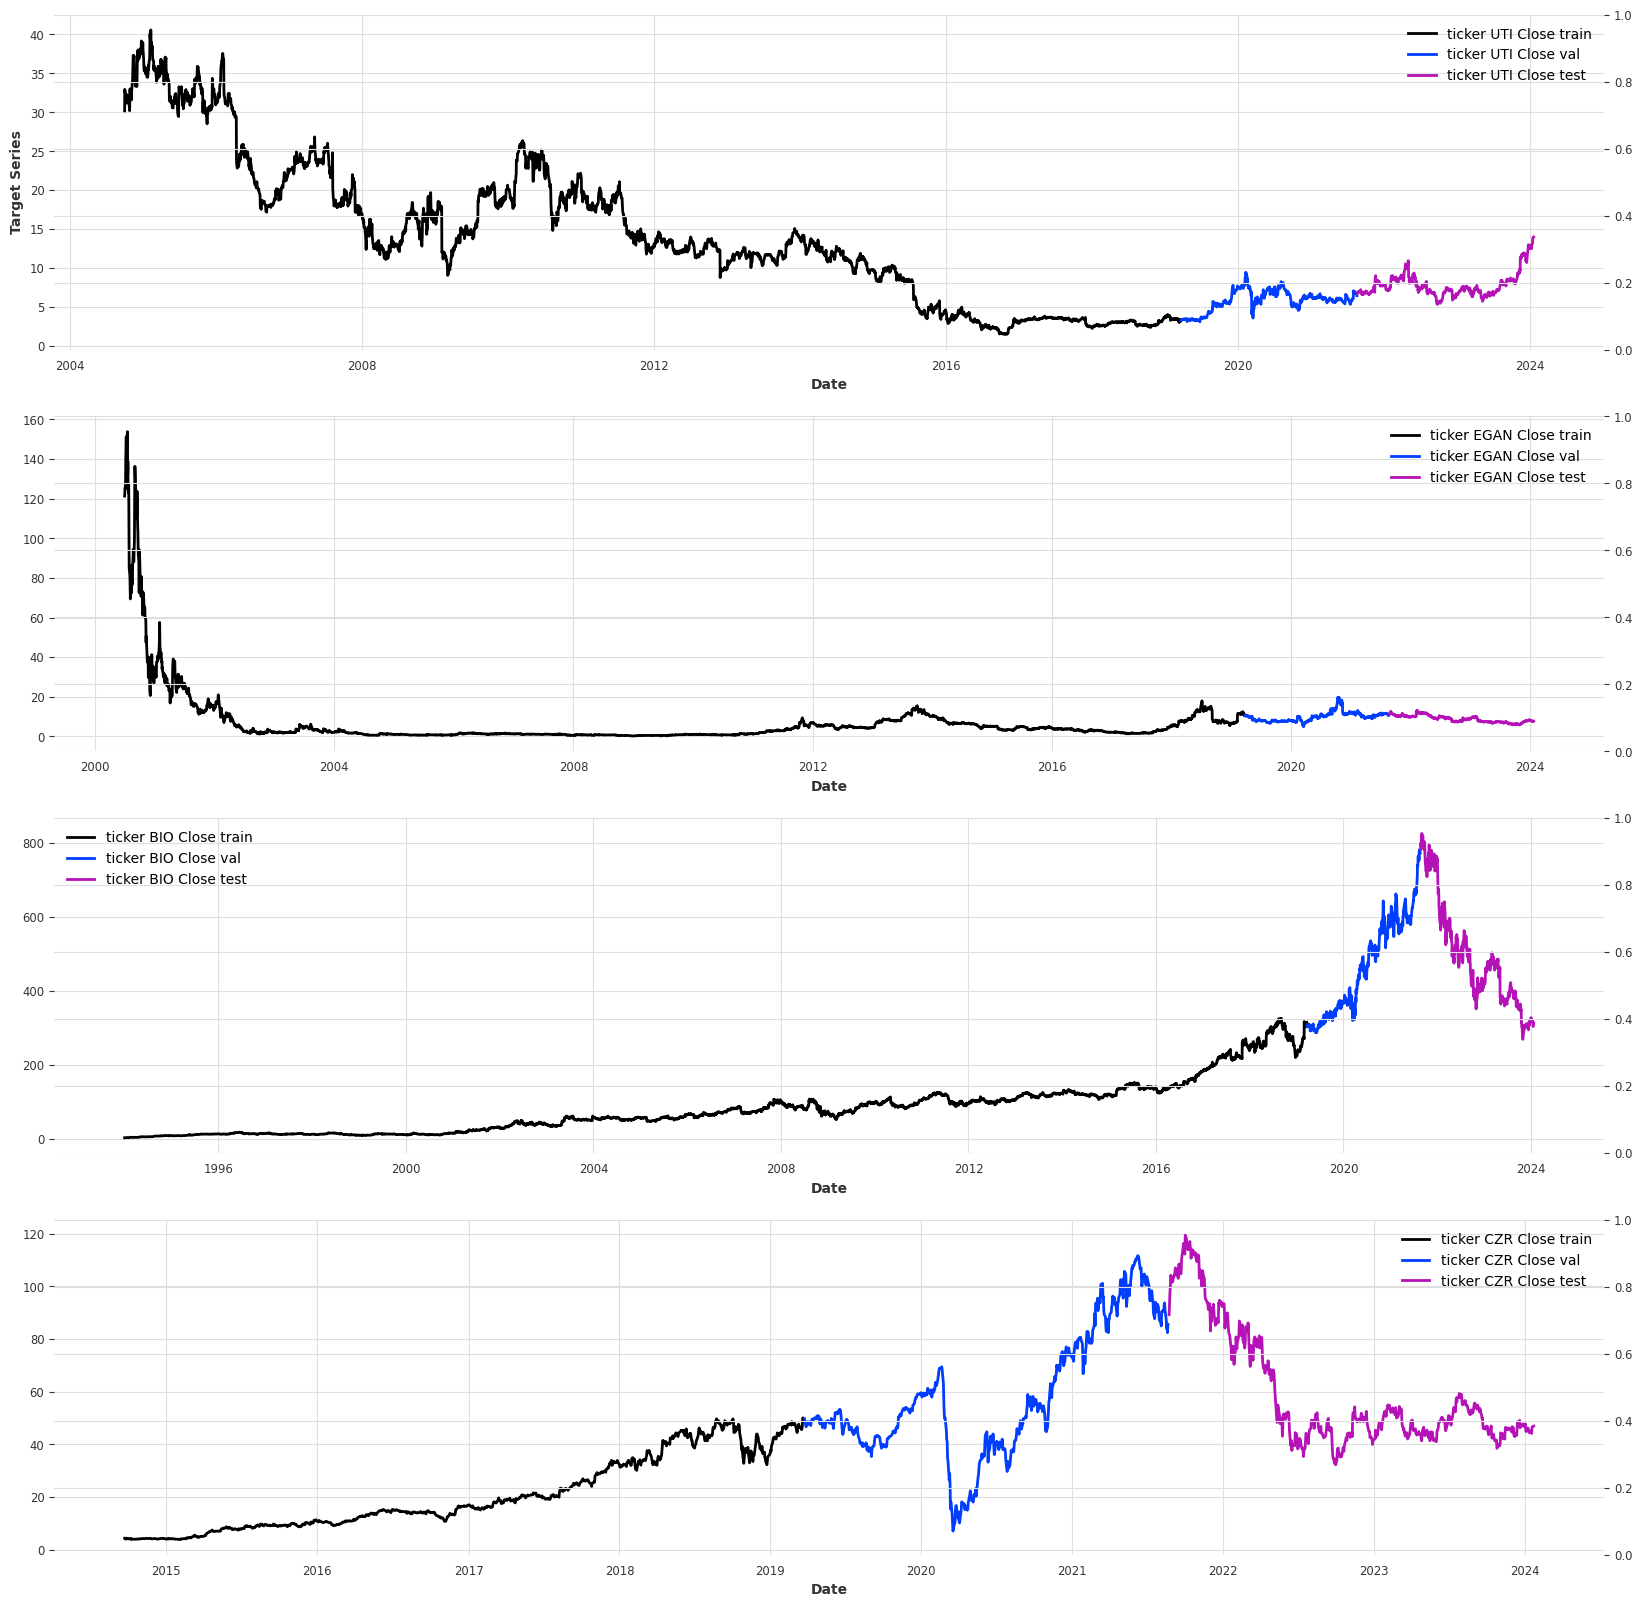

In [157]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break

    train_series[t]['Close'].plot(label=f'ticker {t} Close train', ax=axes[i])
#    train_series[t]['Volume'].plot(label=f'ticker {t} Volume train', ax=axes2[i])

    val_series[t]['Close'].plot(label=f'ticker {t} Close val', ax=axes[i])
#    val_series[t]['Volume'].plot(label=f'ticker {t} Volume val', ax=axes2[i])

    test_series[t]['Close'].plot(label=f'ticker {t} Close test', ax=axes[i])
#    test_series[t]['Volume'].plot(label=f'ticker {t} Volume test', ax=axes2[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

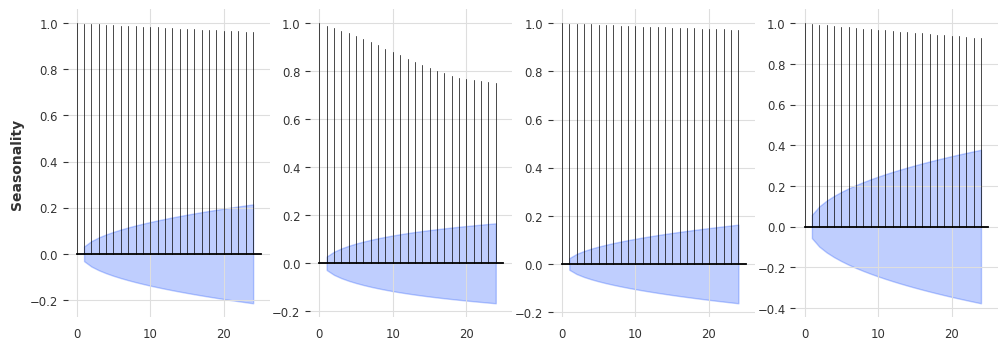

In [158]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i >= n_plot_samples:
        break
    plot_acf(train_series[t]['Close'], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



## Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [159]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
# scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



Model hyperparameter selection

In [160]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 2.24e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    # "accelerator": "auto",
    "accelerator": "gpu", 
    "accelerator": "gpu",
    "devices": [0],
    # "auto_select_gpus": True,
    "callbacks": [],
}

# pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1, "auto_select_gpus": True}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 512, # 256,
    "random_state": 42,
}

In [161]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  if torch.cuda.is_available():
    map_location="cuda"
    # utilize CUDA tensor cores with bfloat16
    # https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
    torch.set_float32_matmul_precision('medium') #  | 'high'
  else:
    map_location="cpu"
  model = TiDEModel.load(saved_model_name, map_location=map_location)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  # using TiDE hyperparameters from Table 8 in section B.3 of the original paper
  # https://arxiv.org/pdf/2304.08424.pdf
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=None, # encoders,
      hidden_size=512,
      num_encoder_layers=2,
      num_decoder_layers=2,
      decoder_output_dim=32,
      temporal_decoder_hidden=128,
      dropout=0.2,
      use_layer_norm=True,
      use_reversible_instance_norm=True,
      n_epochs=n_epochs,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
      log_tensorboard=True,
      nr_epochs_val_period=1
  )
  


Loading saved model


In [162]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [163]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_val_list))
target_test_list = [series for ticker, series in sorted(test_series.items())]
print(len(target_test_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
past_cov_val_list = [series for ticker, series in sorted(past_covariates_val.items())]
print(len(past_cov_val_list))
past_cov_test_list = [series for ticker, series in sorted(past_covariates_test.items())]
print(len(past_cov_test_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


125
125
125
125
125
125
125


In [164]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [165]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))

print(len(target_val_list[0].time_index))
print(len(past_cov_val_list[0].time_index))

print(len(target_test_list[0].time_index))
print(len(past_cov_test_list[0].time_index))

print(len(future_cov_list[0].time_index))


3711
3903
630
630
631
631
4972


In [166]:
target_train_list[0].pd_dataframe()

component        Open      Close
Date                            
2004-12-31  24.850000  24.540001
2005-01-03  24.540001  24.350000
2005-01-04  24.400000  24.040001
2005-01-05  24.020000  23.900000
2005-01-06  23.850000  23.790001
...               ...        ...
2019-03-18  12.860000  12.940000
2019-03-19  12.960000  12.810000
2019-03-20  12.830000  12.720000
2019-03-21  12.760000  12.910000
2019-03-22  12.880000  12.830000

[3711 rows x 2 columns]

In [167]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('2004-12-31 00:00:00'), Timestamp('2019-03-22 00:00:00'))

In [168]:
past_cov_list[0].pd_dataframe().columns

Index(['High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^NDX_Low', '^NDX_Close', '^NDX_Adj Close', '^NDX_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Close', '^SPX_Adj Close', '^SPX_Volume'],
      dtype='object', name='component', length=137)

In [169]:
past_cov_list[0].pd_dataframe()

component        High        Low  Adj Close     Volume  eps  epsEstimated  \
Date                                                                        
2004-04-07  20.600000  20.049999   4.334215  3707500.0 -1.0          0.32   
2004-04-08  20.500000  20.360001   4.319413   301200.0 -1.0          0.32   
2004-04-09  20.475000  19.890000   4.223214   577050.0 -1.0          0.32   
2004-04-12  20.450001  19.420000   4.127016   852900.0 -1.0          0.32   
2004-04-13  19.549999  19.350000   4.124902   226800.0 -1.0          0.32   
...               ...        ...        ...        ...  ...           ...   
2019-03-18  12.960000  12.860000   8.134185   838100.0 -1.0          0.28   
2019-03-19  12.970000  12.750000   8.052467   600500.0 -1.0          0.28   
2019-03-20  12.890000  12.720000   7.995891   649800.0 -1.0          0.28   
2019-03-21  12.930000  12.720000   8.115327   828600.0 -1.0          0.28   
2019-03-22  12.940000  12.780000   8.065040  1090500.0 -1.0          0.28   

component   time  revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                              ...   
2004-04-07   0.0     -1.0      7.270933e+06                 -1.0  ...   
2004-04-08   0.0     -1.0      7.270933e+06                 -1.0  ...   
2004-04-09   0.0     -1.0      7.270933e+06                 -1.0  ...   
2004-04-12   0.0     -1.0      7.270933e+06                 -1.0  ...   
2004-04-13   0.0     -1.0      7.270933e+06                 -1.0  ...   
...          ...      ...               ...                  ...  ...   
2019-03-18   0.0     -1.0      7.997231e+07                 -1.0  ...   
2019-03-19   0.0     -1.0      7.997231e+07                 -1.0  ...   
2019-03-20   0.0     -1.0      7.997231e+07                 -1.0  ...   
2019-03-21   0.0     -1.0      7.997231e+07                 -1.0  ...   
2019-03-22   0.0     -1.0      7.997231e+07                 -1.0  ...   

component      ^NDX_Low   ^NDX_Close  ^NDX_Adj Close   ^NDX_Volume  \
Date                                                                 
2004-04-07  1475.619995  1481.959961     1481.959961  1.774960e+09   
2004-04-08  1478.439941  1485.510010     1485.510010  1.694140e+09   
2004-04-09  1483.394958  1490.720032     1490.720032  1.597750e+09   
2004-04-12  1488.349976  1495.930054     1495.930054  1.501360e+09   
2004-04-13  1469.880005  1472.880005     1472.880005  1.953240e+09   
...                 ...          ...             ...           ...   
2019-03-18  7293.850098  7326.279785     7326.279785  2.302140e+09   
2019-03-19  7321.930176  7349.279785     7349.279785  2.457920e+09   
2019-03-20  7318.419922  7380.750000     7380.750000  2.464230e+09   
2019-03-21  7356.939941  7493.270020     7493.270020  2.502810e+09   
2019-03-22  7323.520020  7326.060059     7326.060059  2.504740e+09   

component     ^SPX_Open    ^SPX_High     ^SPX_Low   ^SPX_Close  \
Date                                                             
2004-04-07  1148.160034  1148.160034  1138.410034  1140.530029   
2004-04-08  1140.530029  1148.969971  1134.520020  1139.319946   
2004-04-09  1139.924988  1148.130005  1136.919983  1142.259949   
2004-04-12  1139.319946  1147.290039  1139.319946  1145.199951   
2004-04-13  1145.199951  1147.780029  1127.699951  1129.439941   
...                 ...          ...          ...          ...   
2019-03-18  2822.610107  2835.409912  2821.989990  2832.939941   
2019-03-19  2840.760010  2852.419922  2823.270020  2832.570068   
2019-03-20  2831.340088  2843.540039  2812.429932  2824.229980   
2019-03-21  2819.719971  2860.310059  2817.379883  2854.879883   
2019-03-22  2844.520020  2846.159912  2800.469971  2800.709961   

component   ^SPX_Adj Close   ^SPX_Volume  
Date                                      
2004-04-07     1140.530029  1.458800e+09  
2004-04-08     1139.319946  1.199800e+09  
2004-04-09     1142.259949  1.151100e+09  
2004-04-12     1145.199951  1.102400e+09  
2004-04-13     1129.

In [170]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('2004-04-07 00:00:00'), Timestamp('2019-03-22 00:00:00'))

In [171]:
target_val_list[0].start_time(), target_val_list[0].end_time()

(Timestamp('2019-03-25 00:00:00'), Timestamp('2021-08-20 00:00:00'))

In [172]:
past_cov_val_list[0].start_time(), past_cov_val_list[0].end_time()

(Timestamp('2019-03-25 00:00:00'), Timestamp('2021-08-20 00:00:00'))

In [173]:
target_test_list[0].start_time(), target_test_list[0].end_time()

(Timestamp('2021-08-23 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [174]:
past_cov_test_list[0].start_time(), past_cov_test_list[0].end_time()

(Timestamp('2021-08-23 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [175]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays                               1.950000e+02
estimatedRevenueLow_p_1                2.869088e+11
estimatedRevenueHigh_p_1               3.753333e+11
estimatedRevenueAvg_p_1                3.392936e+11
estimatedEbitdaLow_p_1                 4.088856e+10
                                           ...     
numberAnalystEstimatedRevenue_p_2_1    9.960000e+03
numberAnalystsEstimatedEps_p_2_1       8.651000e+03
fiscalDateEnding_day_p_2_1             1.541320e+05
fiscalDateEnding_month_p_2_1           5.966400e+04
fiscalDateEnding_year_p_2_1            1.001874e+07
Length: 139, dtype: float64

In [176]:
future_cov_list[0].columns

Index(['holidays', 'estimatedRevenueLow_p_1', 'estimatedRevenueHigh_p_1',
       'estimatedRevenueAvg_p_1', 'estimatedEbitdaLow_p_1',
       'estimatedEbitdaHigh_p_1', 'estimatedEbitdaAvg_p_1',
       'estimatedEbitLow_p_1', 'estimatedEbitHigh_p_1', 'estimatedEbitAvg_p_1',
       ...
       'estimatedSgaExpenseHigh_p_2_1', 'estimatedSgaExpenseAvg_p_2_1',
       'estimatedEpsAvg_p_2_1', 'estimatedEpsHigh_p_2_1',
       'estimatedEpsLow_p_2_1', 'numberAnalystEstimatedRevenue_p_2_1',
       'numberAnalystsEstimatedEps_p_2_1', 'fiscalDateEnding_day_p_2_1',
       'fiscalDateEnding_month_p_2_1', 'fiscalDateEnding_year_p_2_1'],
      dtype='object', name='component', length=139)

In [177]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('2004-12-31 00:00:00'), Timestamp('2024-01-22 00:00:00'))

### Run model training loop

In [178]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, 
          val_series=target_val_list, val_past_covariates=past_cov_val_list, val_future_covariates=future_cov_list,
          verbose=True, num_loader_workers=4, ) # num_loader_workers recommended at 4*n_GPUs
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 4     
4 | past_cov_projection   | _ResidualBlock   | 73.3 K
5 | future_cov_projection | _ResidualBlock   | 74.3 K
6 | encoders              | Sequential       | 6.4 M 
7 | decoders              | Sequential       | 10.7 M
8 | temporal_decoder      | _ResidualBlock   | 34.4 K
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
17.4 M    Trainable params
0         Non-trainable params
17.4 M    Total params
69.761    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


TiDEModel(num_encoder_layers=2, num_decoder_layers=2, decoder_output_dim=32, hidden_size=512, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=128, use_layer_norm=True, dropout=0.2, use_static_covariates=True, optimizer_kwargs={'lr': 0.000224}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'accelerator': 'gpu', 'devices': [0], 'callbacks': []}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, batch_size=512, random_state=42, input_chunk_length=504, output_chunk_length=42, add_encoders=None, use_reversible_instance_norm=True, n_epochs=10, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), model_name=data/canswim_model.pt, log_tensorboard=True, nr_epochs_val_period=1)

### Save model checkpoint

In [179]:
# save model checkpoint
model.save(saved_model_name)


In [180]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
# pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

## Test Model Forecasting

In [181]:
# pred[0]

In [182]:
# pred[0].gaps()

In [183]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

### Plot several forecasts at various future starting points

In [184]:
import matplotlib.dates as mdates

def get_val_start_list():
    val_start_list = []
    for t, target in sorted(target_series.items()):
        val_start_list.append(val_start[t])
    return val_start_list


def get_test_start_list():
    val_test_list = []
    for t, target in sorted(target_series.items()):
        val_test_list.append(test_start[t])
    return val_test_list


def get_pred_start(start_times=None, offset=None):
    pred_start = {}
    bdays_offset = BDay(n=train_history + offset*pred_horizon)
    for t, start_time in start_times.items():
        pred_start[t] = start_time + bdays_offset
    return pred_start    

def get_pred_list(pred_start=None):
    pred_list = []
    for t, target in sorted(target_series.items()):
        pred_series = target.slice(target.start_time(), pred_start[t]-pd.Timedelta(days=1))
        pred_list.append(pred_series)
    return pred_list


def get_past_cov_list(pred_start=None):
    past_cov_list = []
    for t, past_cov in sorted(past_covariates.items()):
        past_covs_sliced = past_cov.slice(past_cov.start_time(), pred_start[t]-pd.Timedelta(days=1))
        past_cov_list.append(past_covs_sliced)
    return past_cov_list

def get_pred(pred_list=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    pred = model.predict(pred_horizon, series=pred_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list, num_loader_workers=4)
    return pred

pred_test_outputs = []
# get predictions at several points in time over the validation set
for w in range(3):
    pred_start = get_pred_start(start_times=test_start, offset=w)
    pred_list = get_pred_list(pred_start)    
    past_cov_list = get_past_cov_list(pred_start)
    # print(f'pred_list: \n{pred_list}')
    pred = get_pred(pred_list=pred_list, past_cov_list=past_cov_list)
    pred_test_outputs.append(pred)


pred_val_outputs = []
# get predictions at several points in time over the validation set
for w in range(10):
    pred_start = get_pred_start(start_times=val_start, offset=w)
    pred_list = get_pred_list(pred_start)    
    past_cov_list = get_past_cov_list(pred_start)
    # print(f'pred_list: \n{pred_list}')
    pred = get_pred(pred_list=pred_list, past_cov_list=past_cov_list)
    pred_val_outputs.append(pred)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

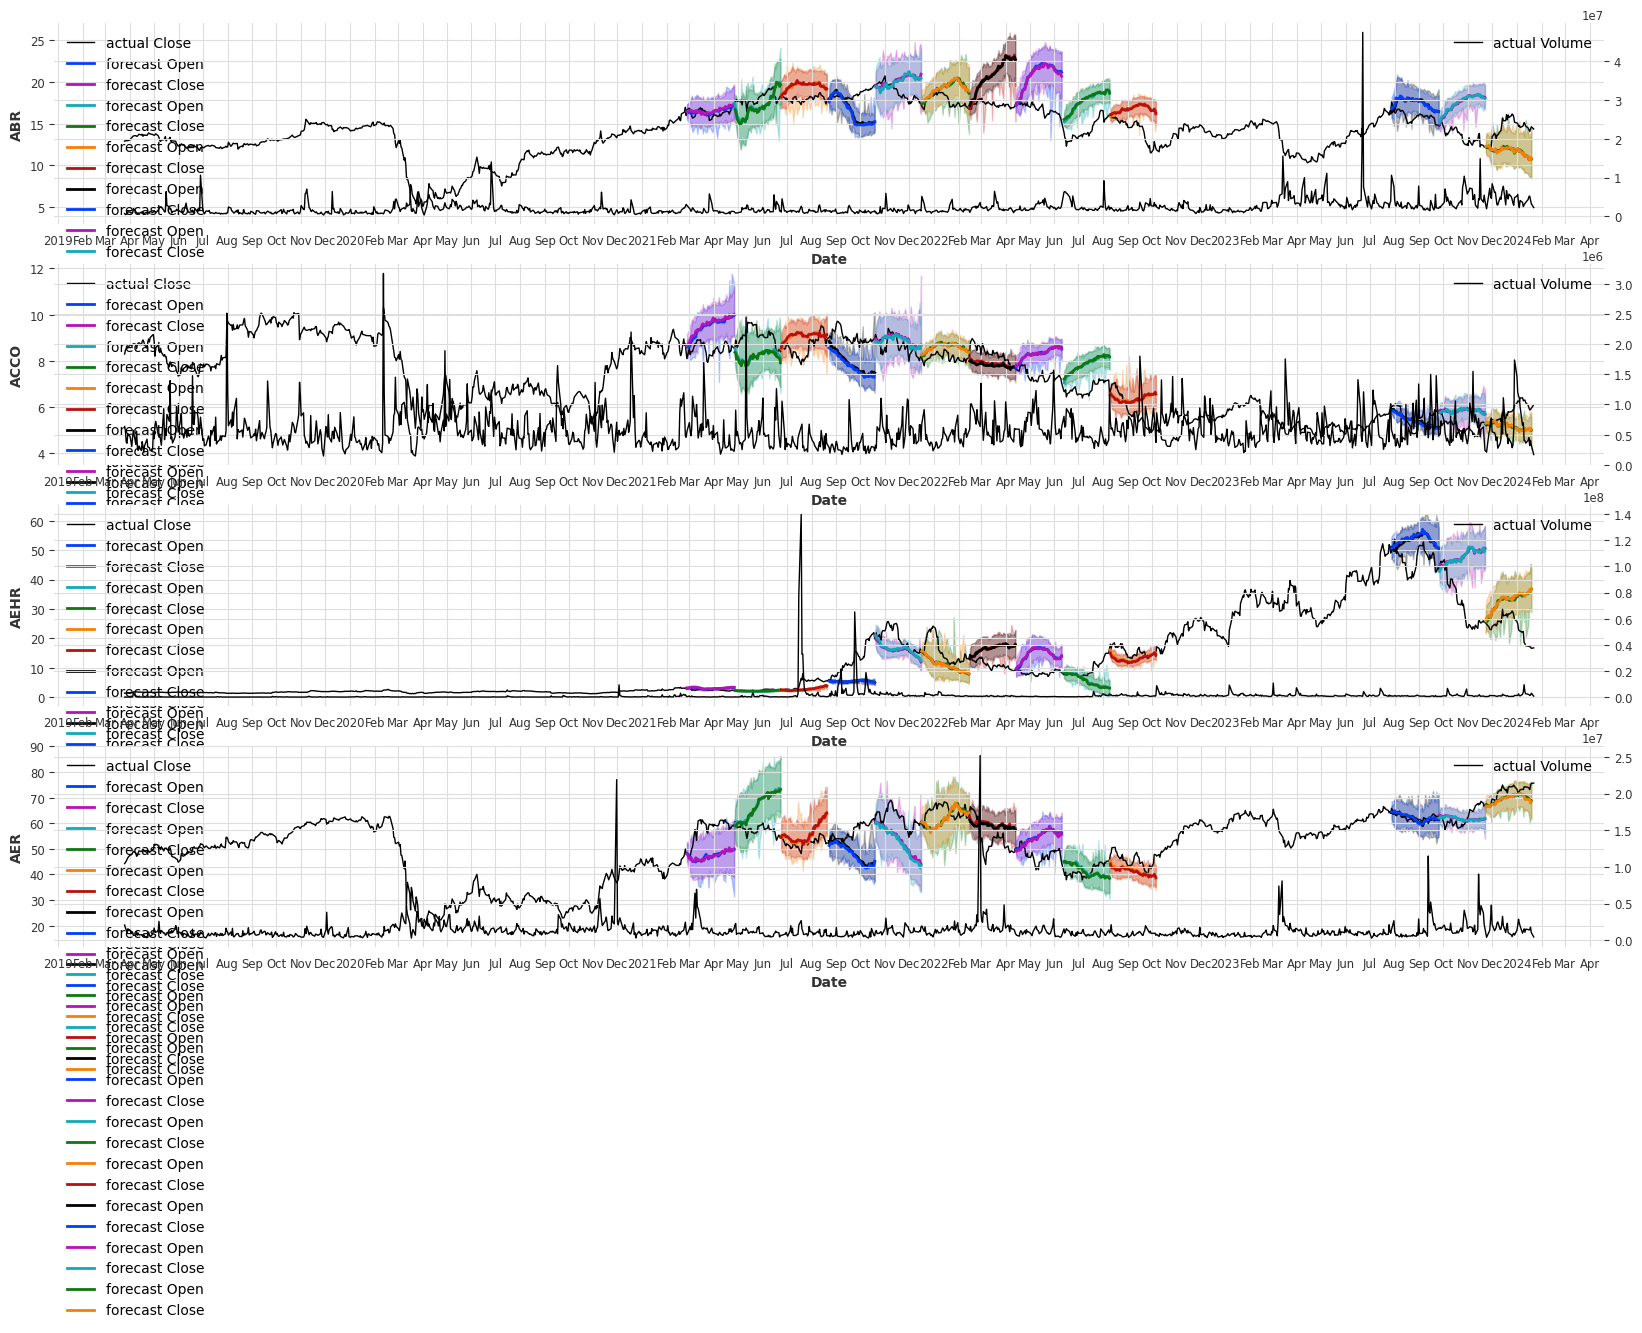

In [185]:
# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

def plot_actual():
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            tsliced = target_series[t]
            actual[t] = tsliced.slice(val_start[t], target.end_time())
            # ax = actual[t]['Open'].plot(label='actual Open', linewidth=1, ax=axes[i])
            ax = actual[t]['Close'].plot(label='actual Close', linewidth=1, ax=axes[i])
            vol = past_covariates[t]['Volume'].slice(val_start[t], target.end_time())
            vol.plot(label='actual Volume', linewidth=1, ax=axes2[i])


def plot_pred(pred_out=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            ax = pred_out[i]['Open'].plot(label=f'forecast Open', linewidth=2, ax=axes[i])
            ax = pred_out[i]['Close'].plot(label=f'forecast Close', linewidth=2, ax=axes[i])
            plt.legend()
            # Major ticks every half year, minor ticks every month,
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.grid(True)
            ax.set_ylabel(f'{t}')



fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 12))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

plot_actual()

# plot predictions at several points in time over the validation set
# plot_pred(pred_outputs=pred_outputs, past_cov_list=past_cov_list)
for pred_out in pred_val_outputs:
    plot_pred(pred_out=pred_out, past_cov_list=past_cov_list)

for pred_out in pred_test_outputs:
    plot_pred(pred_out=pred_out, past_cov_list=past_cov_list)


### Backtest Model


In [186]:
# Backtest model on the full range of test data
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 4, 'n_jobs': -1}
                                          )
    
    return backtest


In [187]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
# forecast_start = test_start-BDay(n=30)
pred_start_list = get_test_start_list()
forecast_start = pred_start_list[0]-BDay(n=30)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list[0], start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list[0], future_covariates=future_cov_list[0])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [188]:
forecast_start

Timestamp('2021-07-12 00:00:00')

In [189]:
forecast_horizon

42

In [190]:
targets_list[0].start_time()

Timestamp('2004-12-31 00:00:00')

In [191]:
backtest[0]

<TimeSeries (DataArray) (time: 1, component: 2, sample: 500)>
array([[[17.61051286, 17.60291407, 17.75115846, 18.77678567,
         17.42333758, 18.05958156, 18.19018504, 18.70514823,
         19.83854835, 17.57425744, 17.78785878, 17.50939309,
         16.69479721, 13.58277616, 15.76367554, 17.94507922,
         16.6005824 , 18.57497834, 16.03347241, 18.761479  ,
         19.24990394, 18.39706233, 17.99796934, 17.15480668,
         19.03182871, 17.83216135, 17.75534451, 17.43701453,
         16.4679811 , 15.12805524, 18.25059635, 17.08089435,
         20.6956856 , 17.67381004, 17.83149724, 17.83609325,
         17.37544866, 14.0444538 , 18.06734895, 18.50106166,
         17.34408817, 18.20130582, 15.22266806, 17.56316369,
         18.4472021 , 18.44183759, 17.92286088, 17.57944685,
         18.31111078, 18.15391854, 14.48213897, 18.4461352 ,
         18.57382927, 18.41808956, 20.32619828, 16.61779065,
         20.29763761, 17.50104977, 17.91109753, 16.81392392,
         18.77103348, 17.41874858, 19.2387307 , 18.95774267,
         18.21343005, 18.73395373, 19.02165709, 18.68345881,
         16.4769698 , 18.42270665, 17.96468402, 18.41227038,
         18.77515941, 19.20717903, 17.42668003, 17.9001835 ,
         17.9152957 , 20.27827101, 18.56549864, 14.24489852,
...
         18.18360893, 17.8175458 , 16.50573313, 18.10748835,
         19.64788195, 19.05736946, 14.90068413, 15.10440024,
         18.35653287, 18.16415116, 17.67829355, 16.76590384,
         17.42997368, 18.47600444, 17.82915263, 18.04774398,
         18.9285727 , 17.46391376, 19.63393977, 16.43897295,
         14.90068413, 15.42568933, 19.05292678, 18.45971562,
         17.17734864, 18.64404503, 16.41210096, 17.29032532,
         16.50734578, 18.27682857, 17.42952681, 17.45818262,
         16.35713576, 17.29378457, 17.59046012, 17.443804  ,
         18.50677543, 20.06105829, 18.45289288, 17.8872335 ,
         19.19486366, 17.55642216, 15.51970693, 16.8549456 ,
         18.08152558, 18.93232249, 19.5546683 , 18.53487253,
         18.48181663, 17.54342458, 16.70318224, 19.53529859,
         18.18608581, 20.02358146, 17.67566725, 17.66659282,
         18.16339618, 18.46635788, 18.26988853, 16.56604294,
         15.75972908, 19.99261547, 18.58867421, 19.32968862,
         18.84199333, 17.4527544 , 17.67153311, 18.09403176,
         17.93230485, 21.01239262, 20.08354523, 16.87210804,
         20.45927535, 20.54437634, 17.21396113, 15.3803741 ,
         17.73006317, 16.35015516, 18.24867168, 17.89438479]]])
Coordinates:
  * time       (time) datetime64[ns] 2021-09-07
  * component  (component) object 'Open' 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


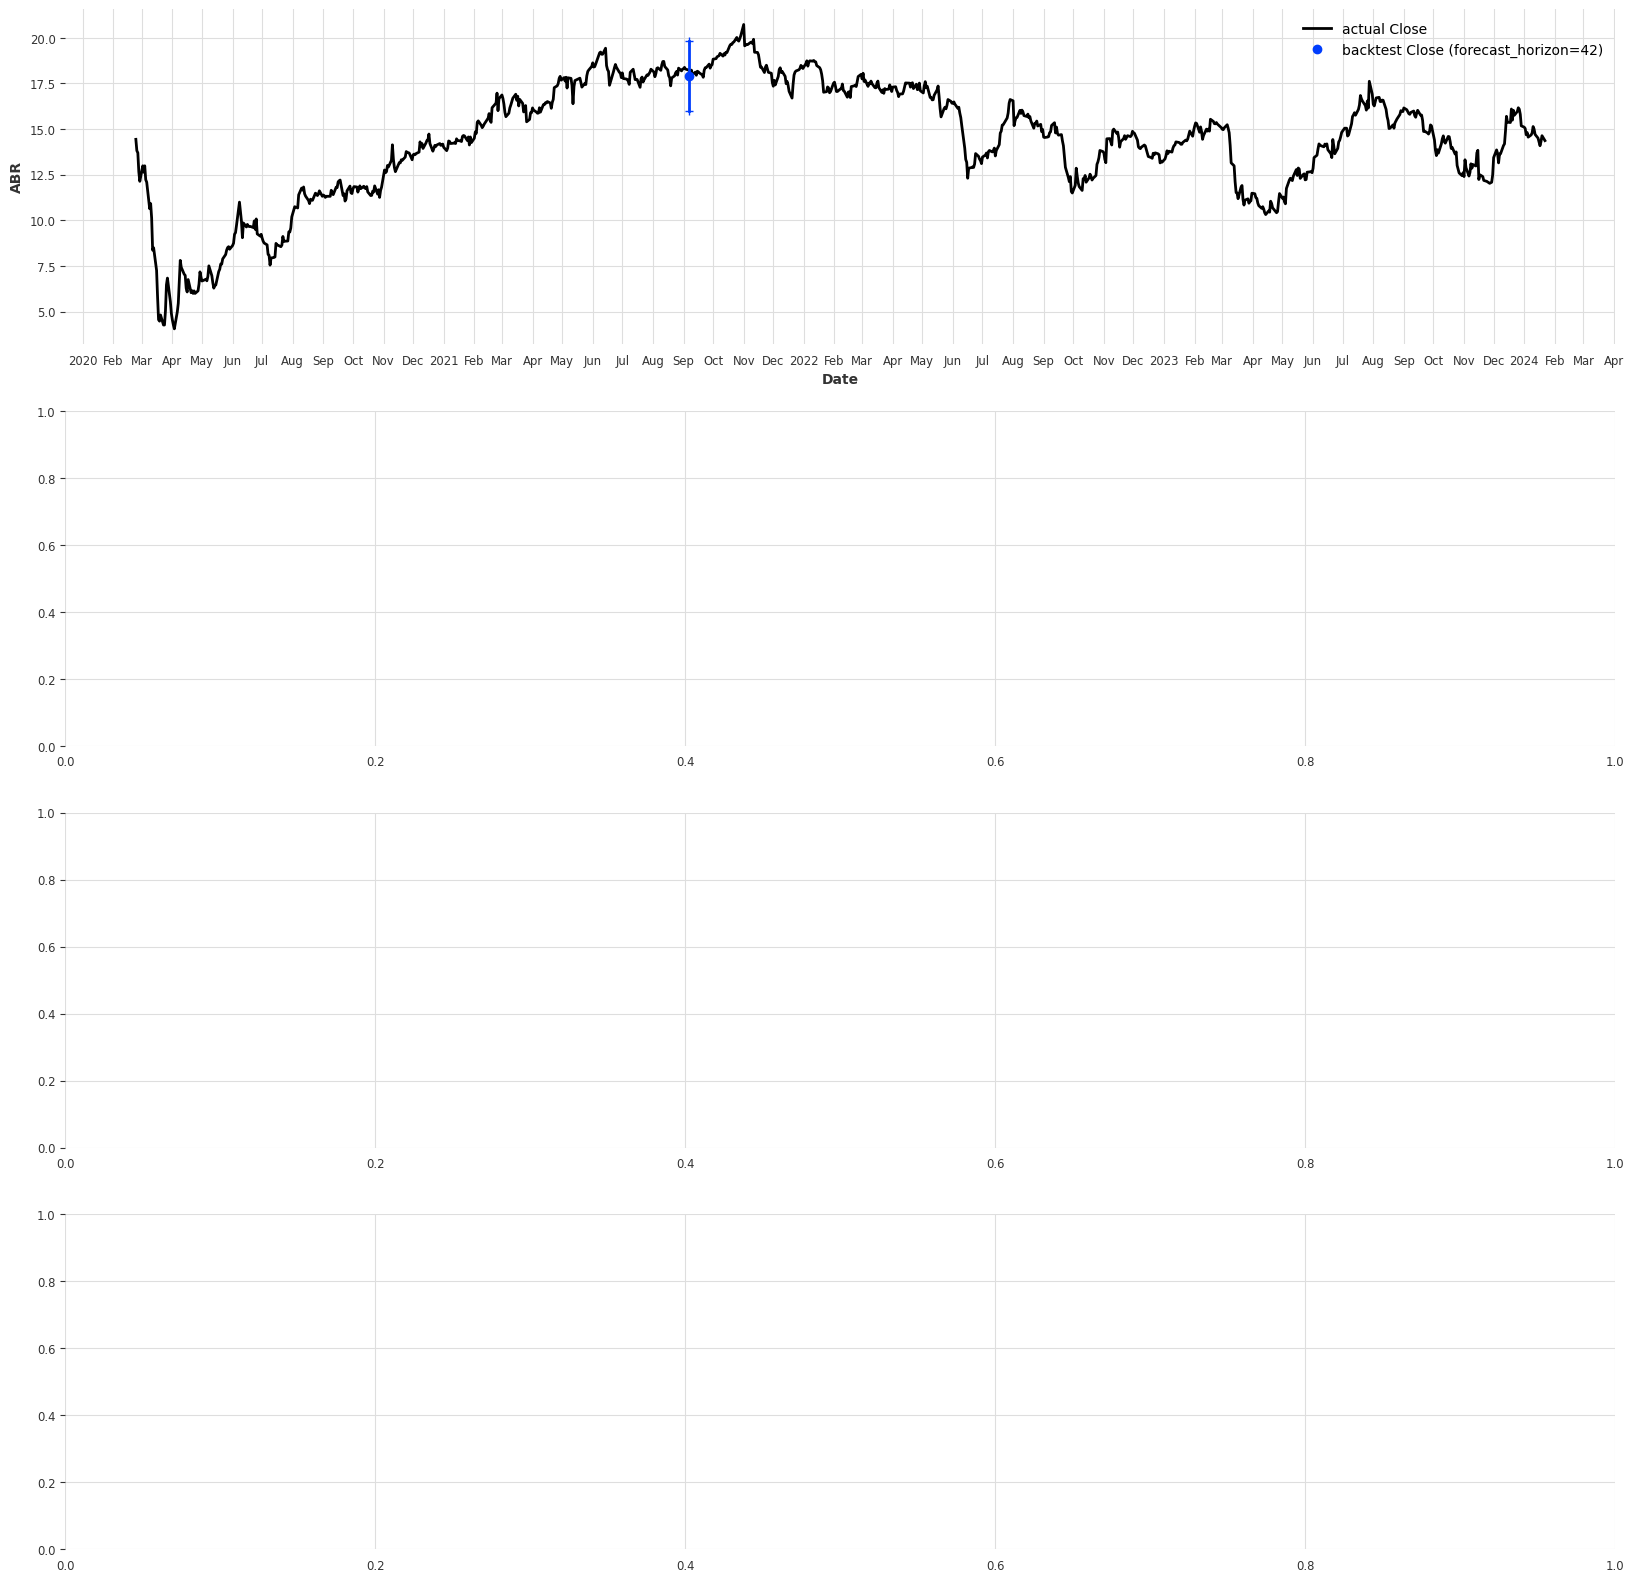

In [192]:


fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
# axes2 = {}
# for i in range(n_plot_samples):
#    axes2[i] = axes[i].twinx()

for i,t in enumerate(sorted(train_series.keys())):
    # if i < n_plot_samples:
    if i == 0:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(forecast_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t]['Close'].plot(label='actual Close', linewidth=2, ax=axes[i])
        # actual[t]['Volume'].plot(label='actual Volume', ax=axes2[i])
        backtest[i]['Close'].plot(label=f'backtest Close (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        # backtest[i]['Volume'].plot(label=f'backtest Volume (forecast_horizon={forecast_horizon})', linewidth=1, ax=axes2[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13), interval=1))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [193]:
assert len(target_train_list[0].gaps()) == 0 # :n_plot_samples]

In [194]:
len(target_train_list[0])

3711

In [195]:
len(target_train_list[0][:len(backtest[0])])

1

In [196]:
assert len(backtest[0].gaps()) == 0

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [197]:
len(backtest[0])

1

In [198]:
print('Backtest RMSE = {}'.format(rmse(target_train_list[0], backtest[0])))


Backtest RMSE = nan


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
